In [103]:
import sys
import os

project_root = os.path.abspath(os.path.join(os.getcwd(), "../.."))
if project_root not in sys.path:
    sys.path.insert(0, project_root)




In [104]:
# conda activate aso_design
import pandas as pd
from scripts.data_genertion.consts import *
from asodesigner.file_utils import read_human_genome_fasta_dict
from asodesigner.consts import *
all_data = pd.read_csv(DATA_PATH / 'data_asoptimizer_updated.csv')


/tmp/ipykernel_5632/1470068205.py:6: DtypeWarning: Columns (20) have mixed types. Specify dtype option on import or set low_memory=False.
  all_data = pd.read_csv(DATA_PATH / 'data_asoptimizer_updated.csv')


Feture generation

In [105]:
from asodesigner.features.RNaseH_features import compute_rnaseh1_dinucleotide_score
from asodesigner.features.RNaseH_features import compute_rnaseh1_score
from asodesigner.features.RNaseH_features import check_motif_presence
from asodesigner.features.RNaseH_features import rnaseh1_dict
from asodesigner.features.RNaseH_features import score_window

In [106]:
all_data["seq_length"].value_counts()


seq_length
16    22860
17     5254
20     4651
18     1067
19      724
15      104
14       63
25       20
10       14
12        4
21        3
22        1
Name: count, dtype: int64

In [107]:
# RNaseH score
# Define the window start positions you want to test (e.g., 0 to 3)
start_positions = [0, 1, 2, 3 , 4, 5 , 6]

# Define the experiments (weight sets)
experiments = ['R4a', 'R4b', 'R7']

# Compute features for each weight set and window start
for exp in experiments:
    weights = rnaseh1_dict(exp)  # get the position-specific nucleotide weights

    for pos in start_positions:
        feature_name = f"RNaseH1_score_{exp}_pos{pos}"
        all_data[feature_name] = all_data.apply(lambda row: compute_rnaseh1_score(row['Sequence'], weights, window_start=pos), axis=1)

# Create a list of feature names for RNaseH1 scores
RNaseH1_features = [f"RNaseH1_score_{exp}_pos{pos}" for exp in experiments for pos in start_positions]




In [108]:
# RNaseH score dinucleotide
# Define the positions you want to test (0–3 is safe for most ASOs ≥16nt)
start_positions = [0, 1, 2, 3 , 4, 5 , 6]
dinuc_experiments = ['R4a_dinuc', 'R4b_dinuc', 'R7_dinuc']

for exp in dinuc_experiments:
    weights = rnaseh1_dict(exp)  # get dinucleotide weights

    for pos in start_positions:
        feature_name = f"RNaseH1_score_dinucleotide_{exp}_pos{pos}"
        all_data[feature_name] = all_data.apply(lambda row: compute_rnaseh1_dinucleotide_score(row['Sequence'], weights, window_start=pos), axis=1)

# Create a list of feature names for RNaseH1 dinucleotide scores
RNaseH1_dinucleotide_features = [f"RNaseH1_score_dinucleotide_{exp}_pos{pos}" for exp in dinuc_experiments for pos in start_positions]



In [109]:
# RNaseH Krel score
# Define the positions to scan within the ASO
start_positions = [0, 1, 2, 3 , 4, 5 , 6]

# These are the exact keys used in rnaseh1_dict
krel_experiments = ['R4a_krel', 'R4b_krel', 'R7_krel']

# Loop over each experiment and position to compute features
for exp in krel_experiments:
    weights = rnaseh1_dict(exp)

    for pos in start_positions:
        feature_name = f"RNaseH1_Krel_score_{exp}_pos{pos}"
        all_data[feature_name] = all_data.apply(lambda row: compute_rnaseh1_score(row['Sequence'], weights, window_start=pos), axis=1)

# Create a list of feature names for RNaseH1 Krel scores
RNaseH1_Krel_features = [f"RNaseH1_Krel_score_{exp}_pos{pos}" for exp in krel_experiments for pos in start_positions]

In [110]:
# RNaseH Kerel score dinucleotide
# Define positions within ASO to test
start_positions = [0, 1, 2, 3 , 4, 5 , 6]

# Use the full keys for dinucleotide Krel weights
krel_dinuc_experiments = ['R4a_krel_dinuc', 'R4b_krel_dinuc', 'R7_krel_dinuc']

for exp in krel_dinuc_experiments:
    weights = rnaseh1_dict(exp)  # e.g., R4a_krel_dinuc

    for pos in start_positions:
        feature_name = f"RNaseH1_Krel_dinucleotide_score_{exp}_pos{pos}"
        all_data[feature_name] = all_data.apply(lambda row: compute_rnaseh1_dinucleotide_score(row['Sequence'], weights, window_start=pos), axis=1)
# Create a list of feature names for RNaseH1 Krel dinucleotide scores
RNaseH1_Krel_dinucleotide_features = [f"RNaseH1_Krel_dinucleotide_score_{exp}_pos{pos}" for exp in krel_dinuc_experiments for pos in start_positions]


In [111]:
RNaseH1_features_list = RNaseH1_features + RNaseH1_dinucleotide_features + RNaseH1_Krel_features + RNaseH1_Krel_dinucleotide_features 

creating the final features

In [112]:
# motif presence
RNeseH1_motif_features = []
motif_list = ['TCCC', 'GGGA', 'CGCG', 'AGGA', 'TGCC' , 'CCCG' ,'TTTT', 'AAAA', 'CCCC', 'GGGG', 'TTAA', 'GCGC']
for motif in motif_list:
    all_data[f'RNaseH1_motif_presence_{motif}'] = all_data['Sequence'].apply(lambda x: check_motif_presence(x, motif))
    RNeseH1_motif_features.append(f'RNaseH1_motif_presence_{motif}')

In [113]:
# Best window_start by (length, experiment name) – standard nucleotide
best_window_start_nt = {
    'R4a': {10: 0, 11: 0, 12: 0, 13: 0, 14: 0, 15: 0, 16: 0, 17: 2,  18: 2, 19: 4, 20: 3, 21: 0, 22: 0, 25:0},
   
    'R4b': {10: 0, 11: 0, 12: 0, 13: 0, 14: 0, 15: 0, 16: 0, 17: 0,  18: 0, 19: 1, 20: 3, 21: 0, 22: 0, 25:0},
 
    'R7': {10: 0, 11: 0, 12: 0, 13: 0, 14: 0, 15: 0, 16: 3, 17: 2,  18: 4, 19: 1, 20: 4, 21: 0, 22: 0, 25:0},
}

for exp in ['R4a', 'R4b', 'R7']:
    weights = rnaseh1_dict(exp)

    def score_row(row):
        length = len(row['Sequence'])
        pos = best_window_start_nt.get(exp, {}).get(length, 0)
        return compute_rnaseh1_score(row['Sequence'], weights, window_start=pos)

    col_name = f"RNaseH1_score_{exp}_best"
    all_data[col_name] = all_data.apply(score_row, axis=1)

RNaseH1_features_best = [f"RNaseH1_score_{exp}_best" for exp in ['R4a', 'R4b', 'R7']]


/tmp/ipykernel_5632/3087856274.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  all_data[col_name] = all_data.apply(score_row, axis=1)
/tmp/ipykernel_5632/3087856274.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  all_data[col_name] = all_data.apply(score_row, axis=1)


In [114]:
# Best window_start by (length, experiment name) – standard dinuc
best_window_start_dinuc = {
    'R4a_dinuc': {10: 0, 11: 0, 12: 0, 13: 0, 14: 0, 15: 0, 16:3, 17: 3,  18: 2, 19: 4, 20: 6, 21: 0, 22: 0, 25:0},
    'R4b_dinuc': {10: 0, 11: 0, 12: 0, 13: 0, 14: 0, 15: 0, 16: 0, 17: 0,  18: 3, 19: 1, 20: 3, 21: 0, 22: 0, 25:0},
    'R7_dinuc':  {10: 0, 11: 0, 12: 0, 13: 0, 14: 0, 15: 0, 16: 0, 17: 3,  18: 4, 19: 6, 20: 3, 21: 0, 22: 0, 25:0},
}

for exp in ['R4a_dinuc', 'R4b_dinuc', 'R7_dinuc']:
    weights = rnaseh1_dict(exp)

    def score_row(row):
        length = len(row['Sequence'])
        pos = best_window_start_dinuc.get(exp, {}).get(length, 0)
        return compute_rnaseh1_dinucleotide_score(row['Sequence'], weights, window_start=pos)

    col_name = f"RNaseH1_score_dinucleotide_{exp}_best"
    all_data[col_name] = all_data.apply(score_row, axis=1)

RNaseH1_dinucleotide_features_best = [f"RNaseH1_score_dinucleotide_{exp}_best" for exp in ['R4a_dinuc', 'R4b_dinuc', 'R7_dinuc']]


/tmp/ipykernel_5632/2138491062.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  all_data[col_name] = all_data.apply(score_row, axis=1)
/tmp/ipykernel_5632/2138491062.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  all_data[col_name] = all_data.apply(score_row, axis=1)
/tmp/ipykernel_5632/2138491062.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. T

In [115]:
# Best window_start by (length, experiment name) – Krel nucleotide
best_window_start_krel = {
    'R4a_krel': {10: 0, 11: 0, 12: 0, 13: 0, 14: 0, 15: 0, 16: 0, 17: 3,  18: 2, 19: 4, 20: 3, 21: 0, 22: 0, 25:0},
    'R4b_krel': {10: 0, 11: 0, 12: 0, 13: 0, 14: 0, 15: 0, 16: 0, 17: 1,  18: 3, 19: 1, 20: 3, 21: 0, 22: 0, 25:0},
    'R7_krel':  {10: 0, 11: 0, 12: 0, 13: 0, 14: 0, 15: 0, 16: 3, 17: 2,  18: 4, 19: 6, 20: 4, 21: 0, 22: 0, 25:0},
}

for exp in ['R4a_krel', 'R4b_krel', 'R7_krel']:
    weights = rnaseh1_dict(exp)

    def score_row(row):
        length = len(row['Sequence'])
        pos = best_window_start_krel.get(exp, {}).get(length, 0)
        return compute_rnaseh1_score(row['Sequence'], weights, window_start=pos)

    col_name = f"RNaseH1_Krel_score_{exp}_best"
    all_data[col_name] = all_data.apply(score_row, axis=1)

RNaseH1_Krel_features_best = [f"RNaseH1_Krel_score_{exp}_best" for exp in ['R4a_krel', 'R4b_krel', 'R7_krel']]


/tmp/ipykernel_5632/3165251078.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  all_data[col_name] = all_data.apply(score_row, axis=1)
/tmp/ipykernel_5632/3165251078.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  all_data[col_name] = all_data.apply(score_row, axis=1)
/tmp/ipykernel_5632/3165251078.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. T

In [116]:
# Best window_start by (length, experiment name) - Krel dinucleotide
best_window_start_krel_dinuc = {
    'R4a_krel_dinuc': {10: 0, 11: 0, 12: 0, 13: 0, 14: 0, 15: 0, 16: 2, 17: 1,  18: 2, 19: 4, 20: 6, 21: 0, 22: 0, 25:0},

    'R4b_krel_dinuc': {10: 0, 11: 0, 12: 0, 13: 0, 14: 0, 15: 0, 16: 0, 17: 0,  18: 3, 19: 1, 20: 3, 21: 0, 22: 0, 25:0},

    'R7_krel_dinuc': {10: 0, 11: 0, 12: 0, 13: 0, 14: 0, 15: 0, 16: 0, 17: 3,  18: 4, 19: 6, 20: 3, 21: 0, 22: 0, 25:0},
}

for exp in ['R4a_krel_dinuc', 'R4b_krel_dinuc', 'R7_krel_dinuc']:
    weights = rnaseh1_dict(exp)

    def score_row(row):
        length = len(row['Sequence'])
        pos = best_window_start_krel_dinuc.get(exp, {}).get(length, 0)  # default to 0 if not found
        return compute_rnaseh1_dinucleotide_score(row['Sequence'], weights, window_start=pos)

    col_name = f"RNaseH1_Krel_dinucleotide_score_{exp}_best"
    all_data[col_name] = all_data.apply(score_row, axis=1)

# Create a list of feature names for the best Krel dinucleotide scores
RNaseH1_Krel_dinucleotide_features_best = [f"RNaseH1_Krel_dinucleotide_score_{exp}_best" for exp in ['R4a_krel_dinuc', 'R4b_krel_dinuc', 'R7_krel_dinuc']]




/tmp/ipykernel_5632/609183174.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  all_data[col_name] = all_data.apply(score_row, axis=1)
/tmp/ipykernel_5632/609183174.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  all_data[col_name] = all_data.apply(score_row, axis=1)
/tmp/ipykernel_5632/609183174.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To g

In [117]:
RNaseH1_best_features_list = RNaseH1_Krel_dinucleotide_features_best +RNaseH1_Krel_features_best +RNaseH1_dinucleotide_features_best +RNaseH1_features_best

clean the data

In [118]:
import numpy as np

all_data_no_nan = all_data.dropna(subset=[INHIBITION]).copy()
all_data_no_nan.loc[:, 'log_inhibition'] = -np.log(-all_data_no_nan[INHIBITION] + 100.001)

In [119]:
all_data_no_nan_human = all_data_no_nan[all_data_no_nan[CELL_LINE_ORGANISM] == 'human']
genes = all_data_no_nan[CANONICAL_GENE].copy()
genes_u = list(set(genes))
genes_u.remove('HBV')
genes_u.remove('negative_control')

In [120]:
from asodesigner.read_human_genome import get_locus_to_data_dict
import pickle
from asodesigner.consts import CACHE_DIR


cache_path = CACHE_DIR / 'gene_to_data_simple_cache.pickle'
if not cache_path.exists():
    gene_to_data = get_locus_to_data_dict(include_introns=True, gene_subset=genes_u)
    with open(cache_path, 'wb') as f:
        pickle.dump(gene_to_data, f)
else:
    with open(cache_path, 'rb') as f:
        gene_to_data = pickle.load(f)

In [121]:
from asodesigner.util import get_antisense
import numpy as np

# Filter relevant genes
all_data_human_gene = all_data_no_nan_human[all_data_no_nan_human[CANONICAL_GENE].isin(genes_u)].copy()

# Column names and their purpose
SENSE_START = 'sense_start'               # Genomic index of ASO binding site in pre-mRNA
SENSE_LENGTH = 'sense_length'             # Length of the ASO (in nucleotides)
SENSE_TYPE = 'sense_type'                 # Whether the binding site falls in an exon or intron
CDS_SEQUENCE = 'cds_sequence'             # Full coding region (CDS) of the gene
IN_CODING_REGION = 'in_coding_region'     # Whether the ASO binds inside the CDS on a real exon

# Flank sizes to extract from pre-mRNA and CDS (separately)
FLANK_SIZES_PREMRNA = [20, 30, 40, 50, 60, 70]
FLANK_SIZES_CDS = [20, 30, 40, 50, 60, 70]  # Can be customized independently

# Initialize new columns
all_data_human_gene[SENSE_START] = 0
all_data_human_gene[SENSE_LENGTH] = 0
all_data_human_gene[SENSE_TYPE] = "NA"
all_data_human_gene[CDS_SEQUENCE] = ""
all_data_human_gene[IN_CODING_REGION] = False

# Initialize pre-mRNA flank sequence columns
for fs in FLANK_SIZES_PREMRNA:
    all_data_human_gene[f"flank_sequence_{fs}"] = ""

# Initialize CDS-based local context columns
for fs in FLANK_SIZES_CDS:
    all_data_human_gene[f"local_coding_region_around_ASO_{fs}"] = ""

# Cache CDS info per gene to avoid redundant work
gene_to_cds_info = {}

for index, row in all_data_human_gene.iterrows():
    gene_name = row[CANONICAL_GENE]
    locus_info = gene_to_data[gene_name]
    pre_mrna = locus_info.full_mrna
    antisense = row[SEQUENCE]
    sense = get_antisense(antisense)

    # Locate ASO binding site in pre-mRNA
    idx = pre_mrna.find(sense)
    all_data_human_gene.loc[index, SENSE_START] = idx
    all_data_human_gene.loc[index, SENSE_LENGTH] = len(antisense)

    if idx != -1:
        # Genomic index correction
        genome_corrected_index = idx + locus_info.exon_indices[0][0]

        # Determine whether in exon or intron
        region_type = "intron"
        for exon_start, exon_end in locus_info.exon_indices:
            if exon_start <= genome_corrected_index <= exon_end:
                region_type = "exon"
                break
        all_data_human_gene.loc[index, SENSE_TYPE] = region_type

        # Extract pre-mRNA flanks
        for fs in FLANK_SIZES_PREMRNA:
            flank_start = max(0, idx - fs)
            flank_end = min(len(pre_mrna), idx + len(sense) + fs)
            flank_seq = pre_mrna[flank_start:flank_end]
            all_data_human_gene.loc[index, f"flank_sequence_{fs}"] = str(flank_seq)

        # Build CDS + genome→mRNA mapping
        if gene_name not in gene_to_cds_info:
            cds_seq = ""
            genome_to_mrna_map = {}
            mrna_idx = 0
            for exon_start, exon_end in locus_info.exon_indices:
                for gpos in range(exon_start, exon_end):
                    if mrna_idx >= len(pre_mrna):
                        break
                    if locus_info.cds_start <= gpos <= locus_info.cds_end:
                        cds_seq += pre_mrna[mrna_idx]
                        genome_to_mrna_map[gpos] = len(cds_seq) - 1
                    mrna_idx += 1
            gene_to_cds_info[gene_name] = (cds_seq, genome_to_mrna_map)
        else:
            cds_seq, genome_to_mrna_map = gene_to_cds_info[gene_name]

        # Save CDS
        all_data_human_gene.loc[index, CDS_SEQUENCE] = cds_seq

        # If in CDS, extract local CDS context regions
        if (
            locus_info.cds_start <= genome_corrected_index <= locus_info.cds_end
            and genome_corrected_index in genome_to_mrna_map
        ):
            all_data_human_gene.loc[index, IN_CODING_REGION] = True
            cds_idx = genome_to_mrna_map[genome_corrected_index]

            for fs in FLANK_SIZES_CDS:
                start = max(0, cds_idx - fs)
                end = min(len(cds_seq), cds_idx + len(sense) + fs)
                local_seq = cds_seq[start:end]
                all_data_human_gene.loc[index, f"local_coding_region_around_ASO_{fs}"] = local_seq


In [122]:
# Filter genes that were not found in genome
all_data_human_gene_premrna = all_data_human_gene[all_data_human_gene[SENSE_START] != -1]



In [123]:
from scipy import stats
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection  import train_test_split, cross_val_score
from sklearn.metrics import make_scorer
import pandas as pd
from scripts.data_genertion.consts import *

In [124]:
all_data_human_gene_premrna_no_nan = all_data_human_gene_premrna.copy()
filtered = all_data_human_gene_premrna_no_nan
filtered = filtered[filtered['Cell line organism'] == 'human']
filtered = filtered[filtered['Cell line organism'] == 'human']
print(len(filtered))
filtered = filtered.dropna(subset=[INHIBITION]).copy()
filtered = filtered.dropna(subset=[DENSITY]).copy()

ONE_HOT_FEATURE_NAMES = [CELL_LINE, TRANSFECTION, MODIFICATION, SENSE_TYPE]
# append more one-hot features 'first_nucleotide', 'second_nucleotide'

for one_hot_feature in ONE_HOT_FEATURE_NAMES:
    filtered = pd.get_dummies(filtered, columns=[one_hot_feature]).copy()

filtered.loc[:, 'log_volume'] = np.log(filtered[VOLUME])
filtered.loc[:, 'log_density'] = np.log(filtered[DENSITY])

# more feature generation
feature_base = [SENSE_START, SENSE_LENGTH]
experiment_features = [VOLUME, 'log_volume', 'log_density', TREATMENT_PERIOD]

one_hot_encoded_features = []
for one_hot_feature in ONE_HOT_FEATURE_NAMES:
    one_hot_encoded_features.append([feature for feature in filtered.columns if one_hot_feature in feature and one_hot_feature != feature])

# Flatten the list of list to a single big list
flat_one_hot_encoded_features = [feature for sublist in one_hot_encoded_features for feature in sublist]

features = feature_base + experiment_features + flat_one_hot_encoded_features + RNaseH1_features_list +RNaseH1_best_features_list

29987


/home/nivd1/miniconda3/envs/aso_design/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


test the features

In [125]:
from scipy.stats import pearsonr, spearmanr
from sklearn.feature_selection import mutual_info_regression
def print_correlations(df, name1, name2, p_value_threshold=None):
    if p_value_threshold is None:
        p_value_threshold = 1
    corr, p_value = pearsonr(df[name1], df[name2])
    if p_value < p_value_threshold:
        print(f"Feature: {name1:<35}, Pearson: {corr:<5.2f}, p-value: {p_value:<10.2} Target: {name2:<35}")
    corr, p_value = spearmanr(df[name1], df[name2])
    if p_value < p_value_threshold:
        print(f"Feature: {name1:<35}, Spearman: {corr:<5.2f}, p-value: {p_value:<10.2} Target: {name2:<35}")

        # MIC (via Mutual Information)
    try:
        mic = mutual_info_regression(df[[name1]], df[name2], discrete_features='auto')[0]
        print(f"Feature: {name1:<35}, MIC:      {mic:<5.2f}                             Target: {name2:<35}")
    except Exception as e:
        print(f"Could not compute MIC for {name1} vs {name2}: {e}")    

In [126]:
import pandas as pd
from scipy.stats import pearsonr, spearmanr, entropy
from sklearn.feature_selection import mutual_info_regression
import numpy as np

def compute_entropy(series, bins=20):
    series = series.astype(float)
    hist, _ = np.histogram(series, bins=bins, density=True)
    hist = hist[hist > 0]
    return entropy(hist, base=2)

def analyze_feature_correlations(df, target, features=None, verbose=False, bins=20):
    """
    Analyzes Pearson, Spearman, and Normalized Mutual Information (NMI_max) between features and a target variable.

    Parameters:
    -----------
    df : pd.DataFrame
    target : str
        Name of the target column.
    features : list of str, optional
        Feature names. If None, use all columns except the target.
    verbose : bool
        Print error messages if True.
    bins : int
        Number of bins for entropy estimation.

    Returns:
    --------
    pd.DataFrame with Pearson, Spearman, and NMI_max results.
    """
    if features is None:
        features = [col for col in df.columns if col != target]

    results = []

    for feature in features:
        try:
            # Drop rows with NaN in either the feature or the target
            valid_mask = df[[feature, target]].notnull().all(axis=1)
            x = df.loc[valid_mask, feature].values
            y = df.loc[valid_mask, target].values

            # Skip if there's not enough data
            if len(x) < 3:
                raise ValueError("Not enough valid data points.")

            pearson_corr, pearson_p = pearsonr(x, y)
            spearman_corr, spearman_p = spearmanr(x, y)
            mi = mutual_info_regression(x.reshape(-1, 1), y, discrete_features='auto')[0]

            H_x = compute_entropy(x, bins=bins)
            H_y = compute_entropy(y, bins=bins)

            nmi_max = mi / max(H_x, H_y) if max(H_x, H_y) > 0 else np.nan

            results.append({
                'Feature': feature,
                'Pearson': round(pearson_corr, 3),
                'Spearman': round(spearman_corr, 3),
                'NMI_max': round(nmi_max, 3)
            })

        except Exception as e:
            if verbose:
                print(f"Error with feature '{feature}': {e}")
            results.append({
                'Feature': feature,
                'Pearson': None,
                'Spearman': None,
                'NMI_max': None
            })

    results_df = pd.DataFrame(results)
    results_df.sort_values(by="NMI_max", ascending=False, inplace=True)
    return results_df


In [127]:
import matplotlib.pyplot as plt

def plot_feature_correlations_by_prefix(results_df, prefix, sort_by='NMI_max', title=None):
    """
    Plots Pearson, Spearman, and MIC correlations for features starting with a given prefix.

    Parameters:
    -----------
    results_df : pd.DataFrame
        The DataFrame containing correlation results (from analyze_feature_correlations).
    prefix : str
        The prefix to filter feature names (e.g., 'tAI_score').
    sort_by : str
        Which column to sort the features by (default: 'NMI_max').
    title : str or None
        Optional custom title for the plot.

    Returns:
    --------
    None
    """
    # Filter features by prefix
    subset_df = results_df[results_df['Feature'].str.startswith(prefix)].copy()
    subset_df = subset_df.dropna(subset=["Pearson", "Spearman", 'NMI_max'])
    
    if subset_df.empty:
        print(f"No features found starting with '{prefix}'")
        return

    # Sort by specified metric
    subset_df.sort_values(by=sort_by, ascending=False, inplace=True)

    # Set x locations and bar width
    features = subset_df['Feature']
    x = range(len(features))
    bar_width = 0.25

    # Plot bars
    plt.figure(figsize=(12, 6))
    plt.bar([i - bar_width for i in x], subset_df['Pearson'], width=bar_width, label='Pearson')
    plt.bar(x, subset_df['Spearman'], width=bar_width, label='Spearman')
    plt.bar([i + bar_width for i in x], subset_df['NMI_max'], width=bar_width, label='NMI_max')

    plt.xticks(x, features, rotation=45, ha='right')
    plt.ylabel('Correlation Value')
    if title:
        plt.title(title)
    else:
        plt.title(f"Correlation Metrics for Features Starting with '{prefix}'")

    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()



def plot_selected_feature_correlations_from_list(results_df, feature_list, sort_by='NMI_max', title=None):
    """
    Plots Pearson, Spearman, and MIC correlations for a given list of features.

    Parameters:
    -----------
    results_df : pd.DataFrame
        The DataFrame containing correlation results.
    feature_list : list of str
        The list of feature names to include in the plot.
    sort_by : str
        Which column to sort the features by (default: 'NMI_max').
    title : str or None
        Optional custom title for the plot.

    Returns:
    --------
    None
    """
    # Filter features by exact name match from list
    subset_df = results_df[results_df['Feature'].isin(feature_list)].copy()
    subset_df = subset_df.dropna(subset=["Pearson", "Spearman", "NMI_max"])
    
    if subset_df.empty:
        print("No matching features found in the provided list.")
        return

    # Sort by specified metric
    subset_df.sort_values(by=sort_by, ascending=False, inplace=True)

    # Set x locations and bar width
    features = subset_df['Feature']
    x = range(len(features))
    bar_width = 0.25

    # Plot bars
    plt.figure(figsize=(12, 6))
    plt.bar([i - bar_width for i in x], subset_df['Pearson'], width=bar_width, label='Pearson')
    plt.bar(x, subset_df['Spearman'], width=bar_width, label='Spearman')
    plt.bar([i + bar_width for i in x], subset_df['NMI_max'], width=bar_width, label='NMI_max')

    plt.xticks(x, features, rotation=45, ha='right')
    plt.ylabel('Correlation Value')
    if title:
        plt.title(title)
    else:
        plt.title("Correlation Metrics for Selected Features")

    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()


In [160]:
new_filtered = filtered.copy()
new_filtered = new_filtered.drop(columns = RNaseH1_features_list)
results_df = analyze_feature_correlations(new_filtered, target='log_inhibition')
display(results_df)

/home/nivd1/miniconda3/envs/aso_design/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4623: RuntimeWarning: invalid value encountered in subtract
  xm = x - xmean


Feature  Pearson  Spearman  NMI_max
13                      Inhibition(%)    0.880     1.000    2.450
1                                ISIS   -0.051    -0.129    0.182
47                        sense_start   -0.027     0.199    0.129
18               Location_in_sequence   -0.022     0.204    0.129
0                               index    0.337     0.325    0.114
..                                ...      ...       ...      ...
59  local_coding_region_around_ASO_40      NaN       NaN      NaN
60  local_coding_region_around_ASO_50      NaN       NaN      NaN
61  local_coding_region_around_ASO_60      NaN       NaN      NaN
62  local_coding_region_around_ASO_70      NaN       NaN      NaN
95                        log_density      NaN       NaN      NaN

[96 rows x 4 columns]

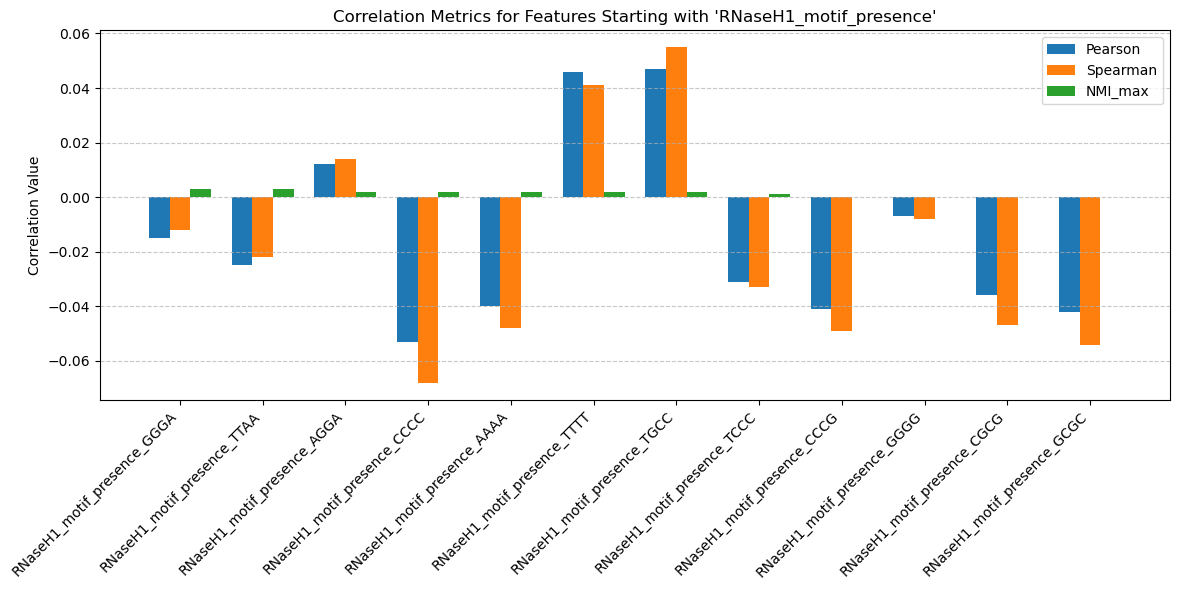

In [161]:
plot_feature_correlations_by_prefix(results_df, prefix='RNaseH1_motif_presence')

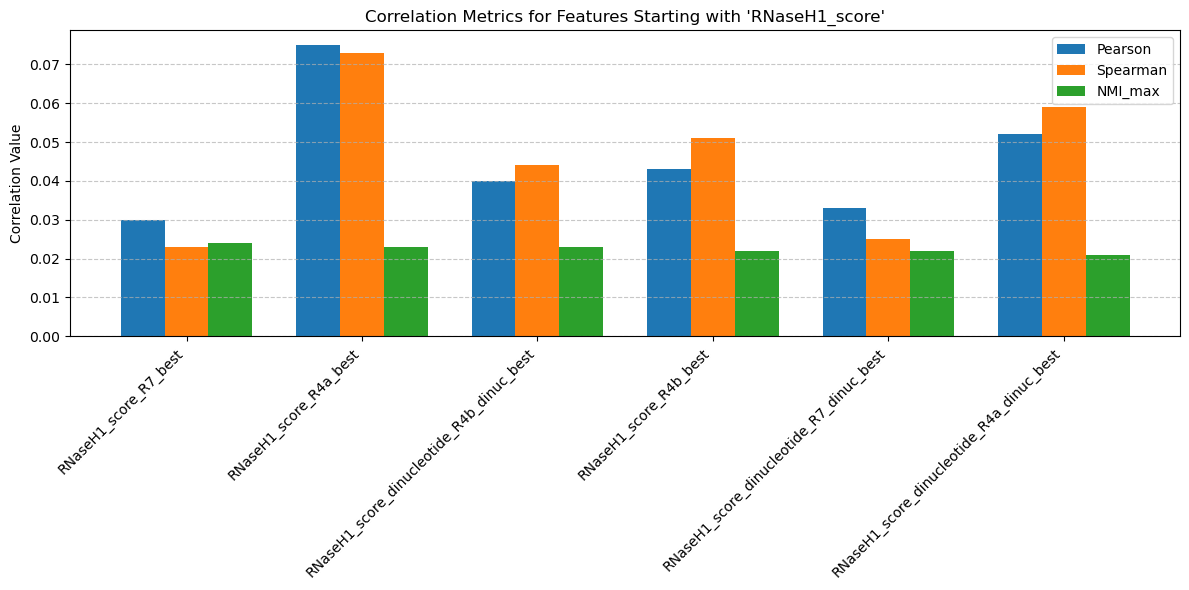

In [162]:
plot_feature_correlations_by_prefix(results_df, prefix='RNaseH1_score')


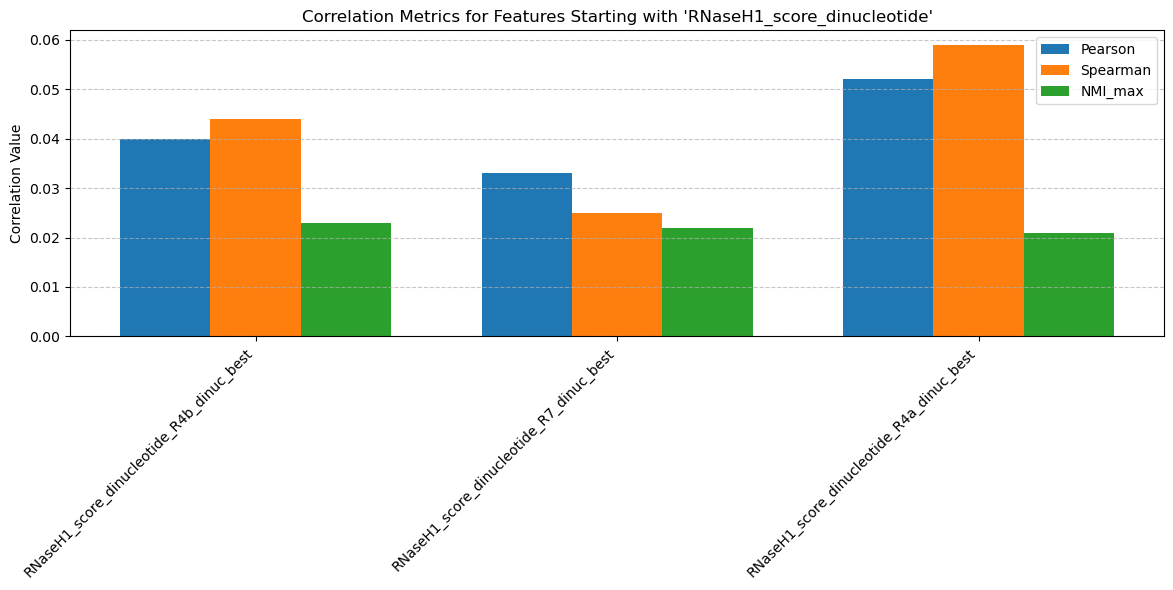

In [164]:
plot_feature_correlations_by_prefix(results_df, prefix='RNaseH1_score_dinucleotide')


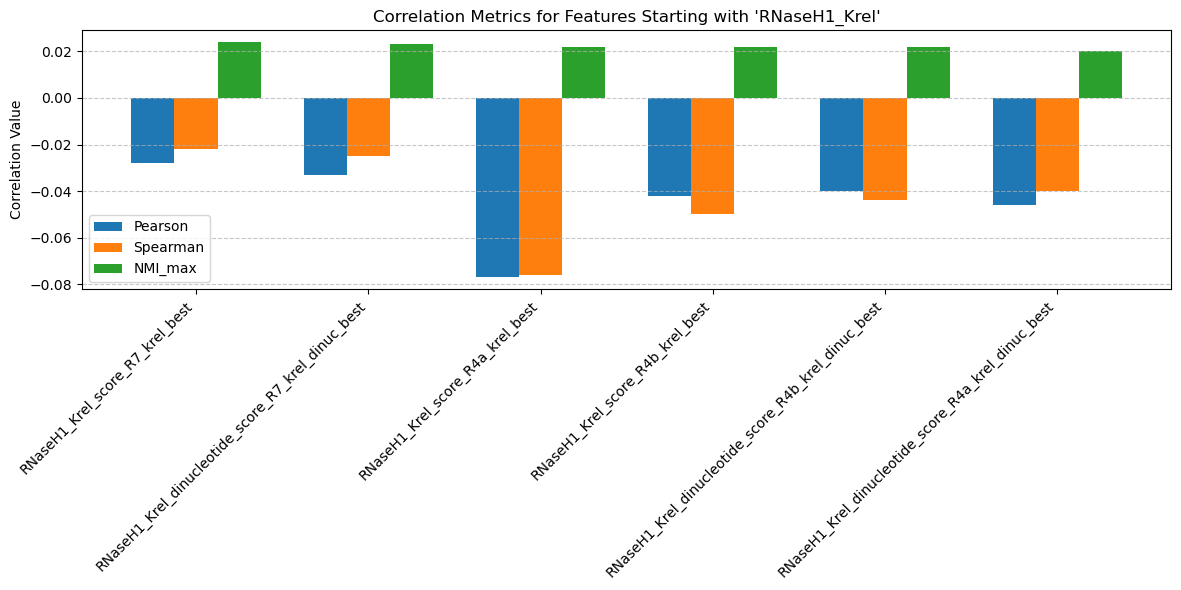

In [165]:
plot_feature_correlations_by_prefix(results_df, prefix='RNaseH1_Krel')

check the correletions for each length

In [132]:
# Make sure 'seq_length' exists
# If not, create it from the Sequence column:
# filtered['seq_length'] = filtered['Sequence'].str.len()

# Lengths you want to split by
lengths = [16, 17, 20, 18, 19, 15, 14, 25, 10, 12, 21, 22]

# Dictionary to store all sub-DataFrames
dfs_by_length = {}
dfs_list = []
# Create separate DataFrames for each length
for length in lengths:
    df = filtered[filtered['Sequence'].str.len() == length].copy()
    dfs_by_length[length] = df
    globals()[f'df_{length}'] = df  # Dynamically assign variables like df_16, df_20
    dfs_list.append(f'df_{length}')
    


In [133]:
filtered['Sequence'].str.len().value_counts().sort_index()


Sequence
16    21191
17     3667
18      426
19      517
20     4186
Name: count, dtype: int64

In [134]:
results_df_16 = analyze_feature_correlations(globals()["df_16"], target='log_inhibition')
results_df_17 = analyze_feature_correlations(globals()["df_17"], target='log_inhibition')
results_df_20 = analyze_feature_correlations(globals()["df_20"], target='log_inhibition')
results_df_18 = analyze_feature_correlations(globals()["df_18"], target='log_inhibition')
results_df_19 = analyze_feature_correlations(globals()["df_19"], target='log_inhibition')
results_df_15 = analyze_feature_correlations(globals()["df_15"], target='log_inhibition')
results_df_14 = analyze_feature_correlations(globals()["df_14"], target='log_inhibition')
results_df_25 = analyze_feature_correlations(globals()["df_25"], target='log_inhibition')
results_df_10 = analyze_feature_correlations(globals()["df_10"], target='log_inhibition')
results_df_12 = analyze_feature_correlations(globals()["df_12"], target='log_inhibition')
results_df_21 = analyze_feature_correlations(globals()["df_21"], target='log_inhibition')
results_df_22 = analyze_feature_correlations(globals()["df_22"], target='log_inhibition')

/tmp/ipykernel_5632/3995343351.py:48: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  pearson_corr, pearson_p = pearsonr(x, y)
/tmp/ipykernel_5632/3995343351.py:49: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  spearman_corr, spearman_p = spearmanr(x, y)
/tmp/ipykernel_5632/3995343351.py:48: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  pearson_corr, pearson_p = pearsonr(x, y)
/tmp/ipykernel_5632/3995343351.py:49: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  spearman_corr, spearman_p = spearmanr(x, y)
/tmp/ipykernel_5632/3995343351.py:48: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  pearson_corr, pearson_p = pearsonr(x, y)
/tmp/ipykernel_5632/3995343351.py:49: ConstantInputWarning: An input array is constant; the correlation coefficient is 

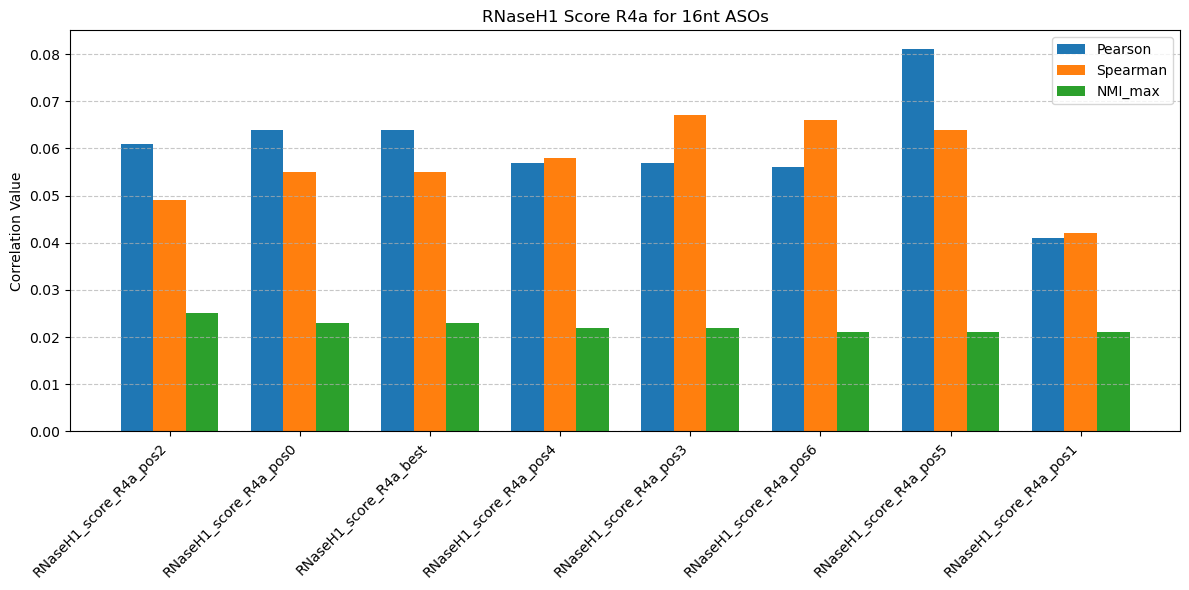

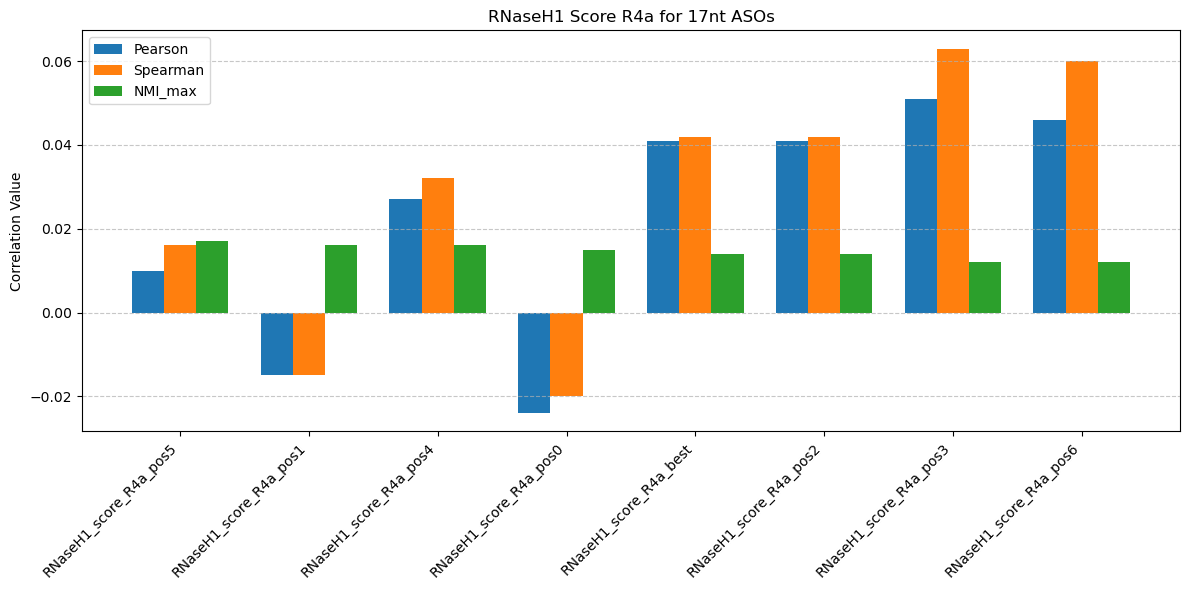

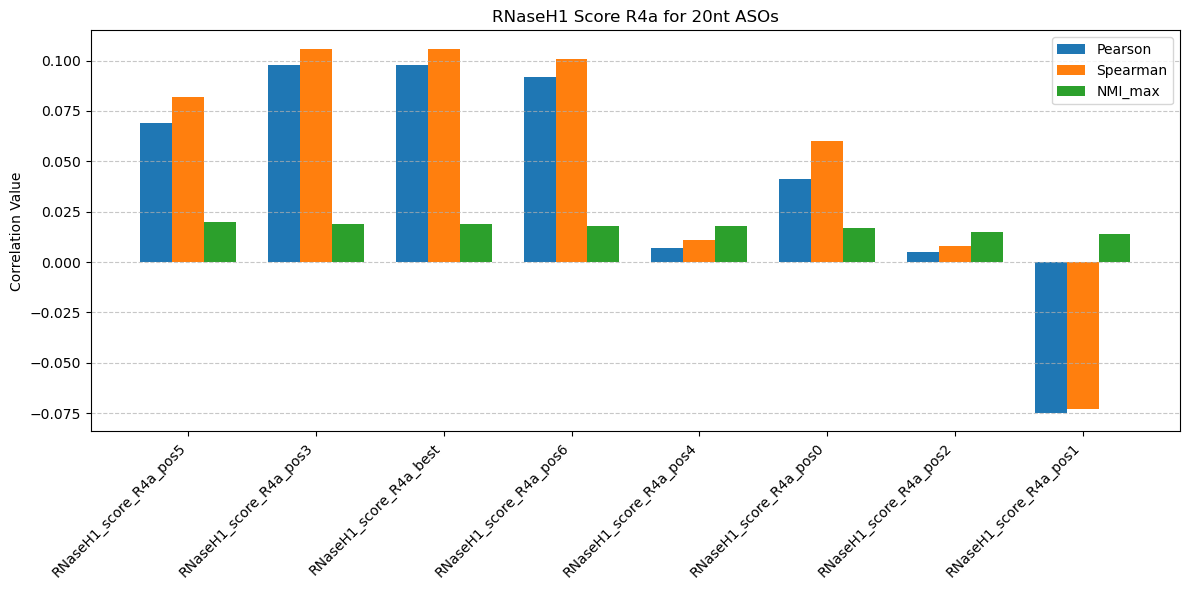

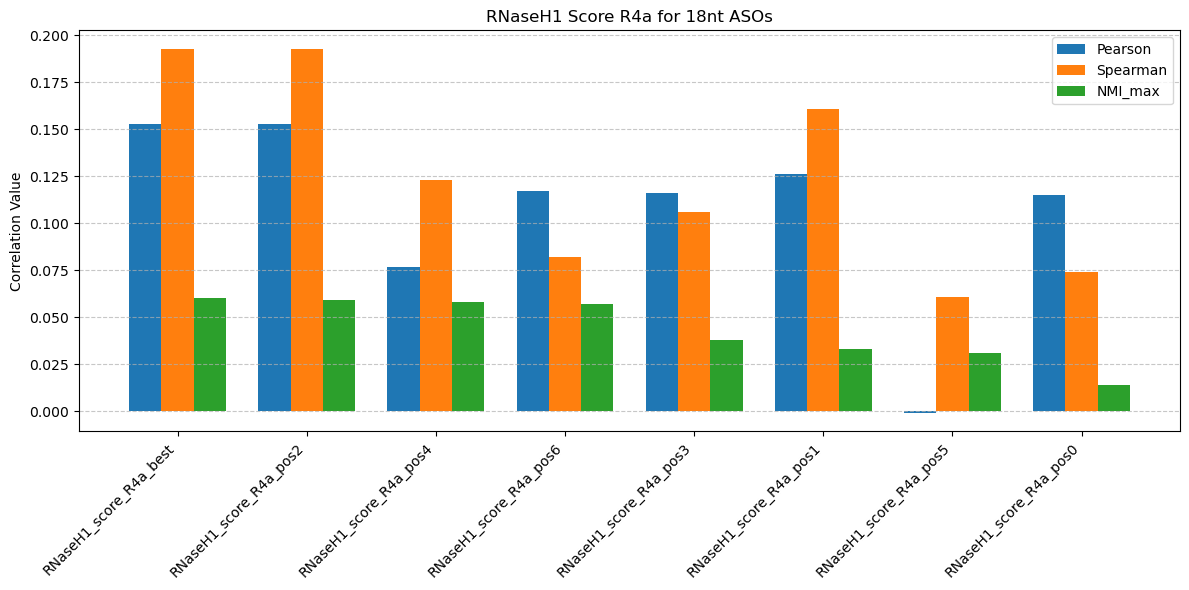

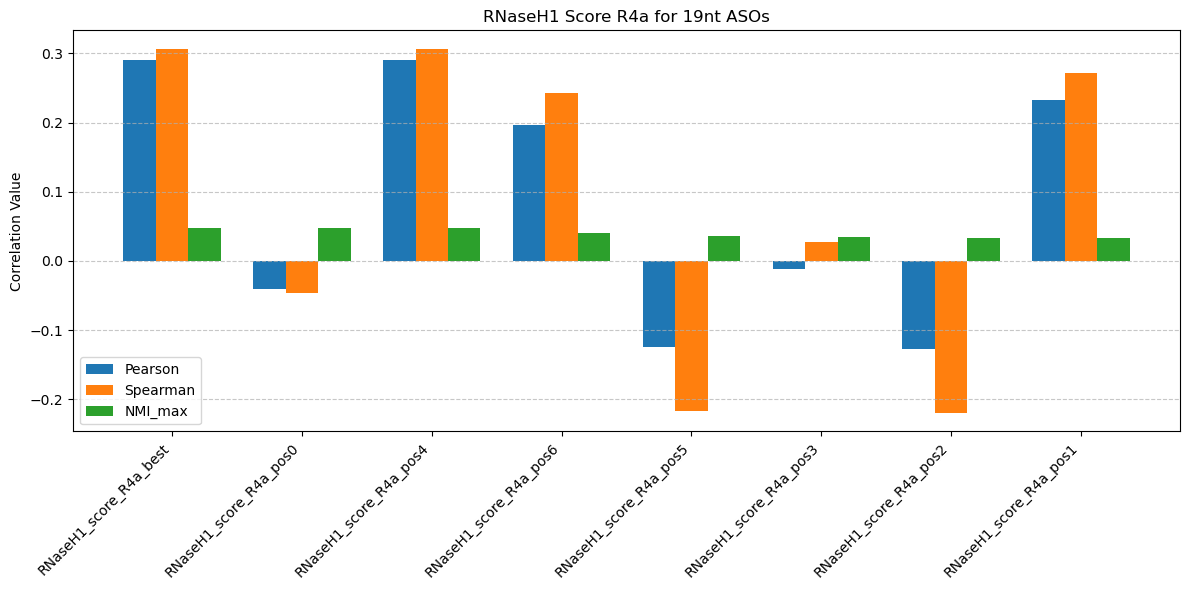

No features found starting with 'RNaseH1_score_R4a'


In [ ]:
plot_feature_correlations_by_prefix(results_df_16, prefix='RNaseH1_score_R4a', title='RNaseH1 Score R4a for 16nt ASOs')
plot_feature_correlations_by_prefix(results_df_17, prefix='RNaseH1_score_R4a', title='RNaseH1 Score R4a for 17nt ASOs')
plot_feature_correlations_by_prefix(results_df_20, prefix='RNaseH1_score_R4a', title='RNaseH1 Score R4a for 20nt ASOs')
plot_feature_correlations_by_prefix(results_df_18, prefix='RNaseH1_score_R4a', title='RNaseH1 Score R4a for 18nt ASOs') 
plot_feature_correlations_by_prefix(results_df_19, prefix='RNaseH1_score_R4a', title='RNaseH1 Score R4a for 19nt ASOs')
plot_feature_correlations_by_prefix(results_df_15, prefix='RNaseH1_score_R4a', title='RNaseH1 Score R4a for 15nt ASOs')
plot_feature_correlations_by_prefix(results_df_22, prefix='RNaseH1_score_R4a', title='RNaseH1 Score R4a for 22nt ASOs')


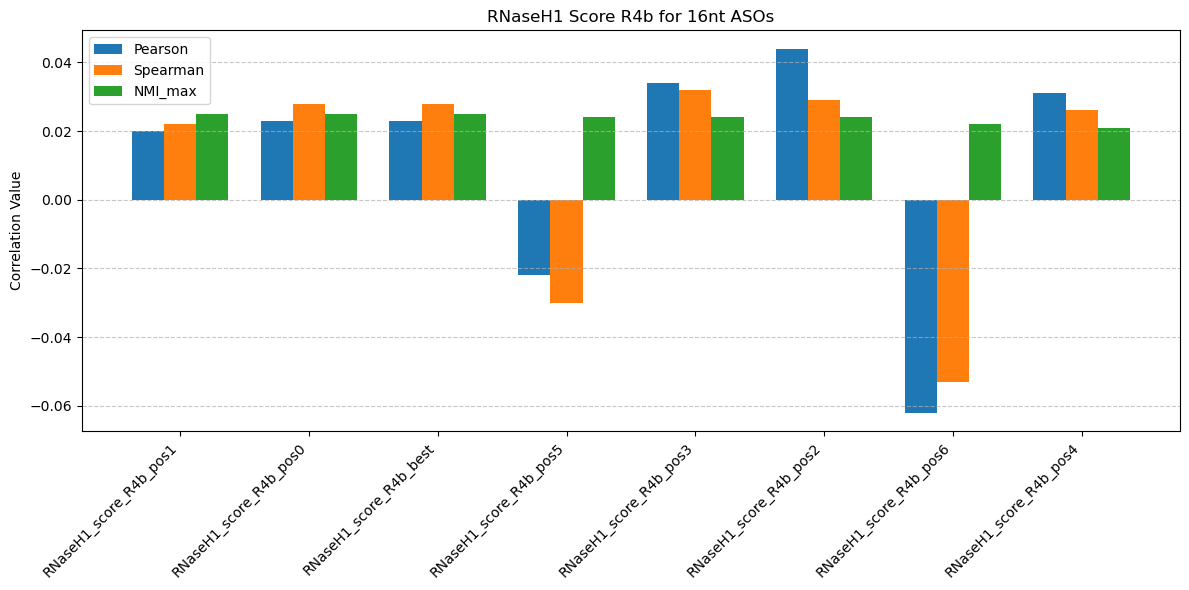

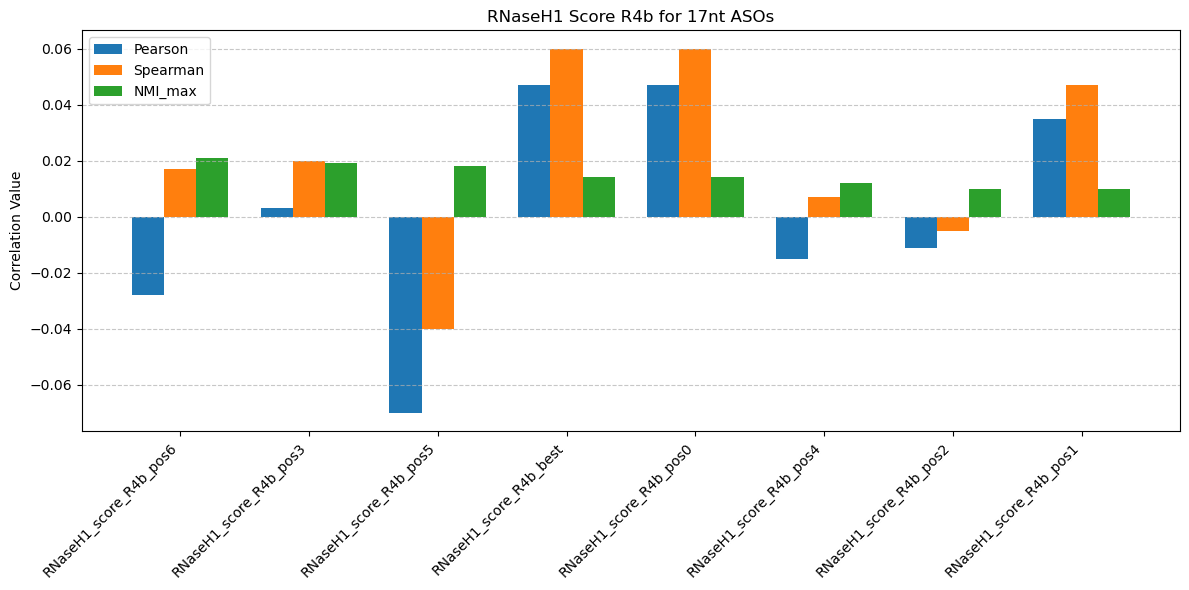

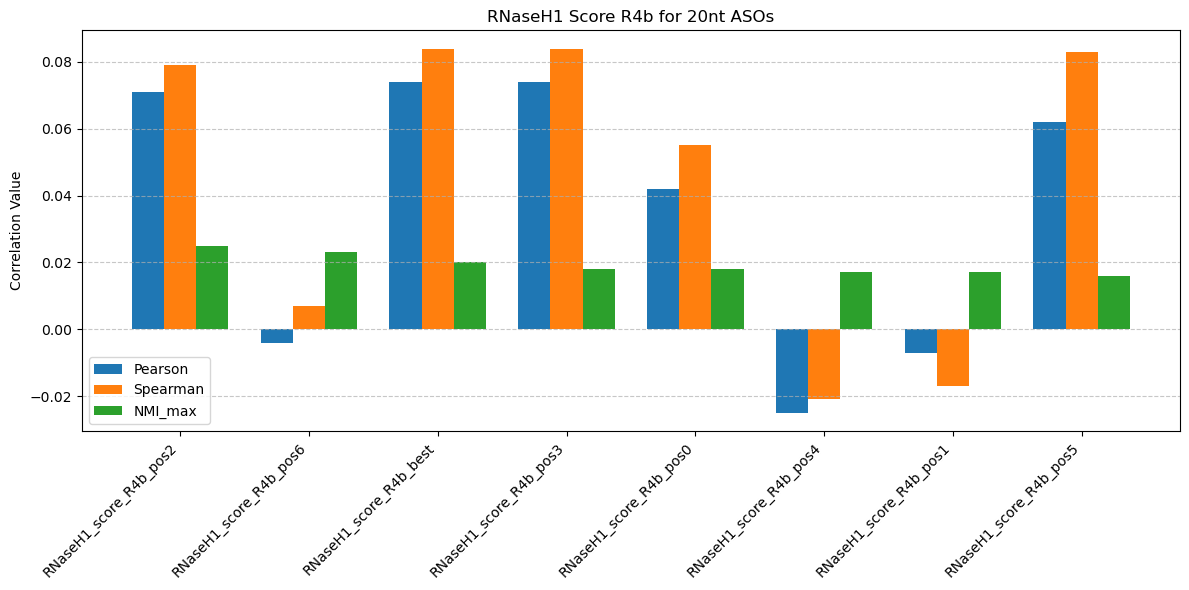

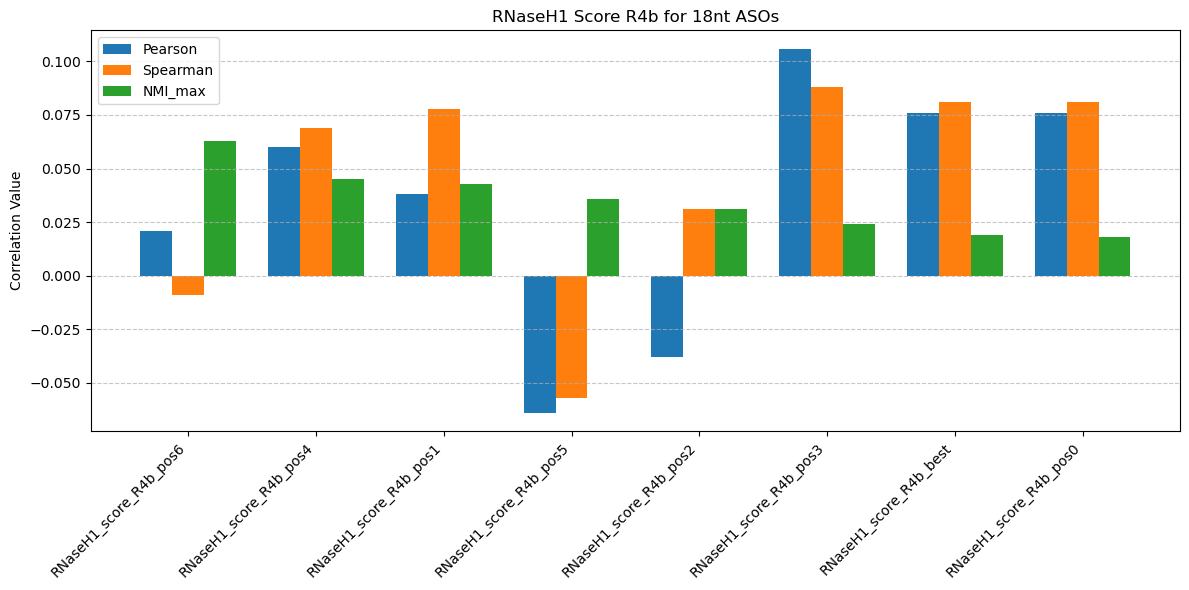

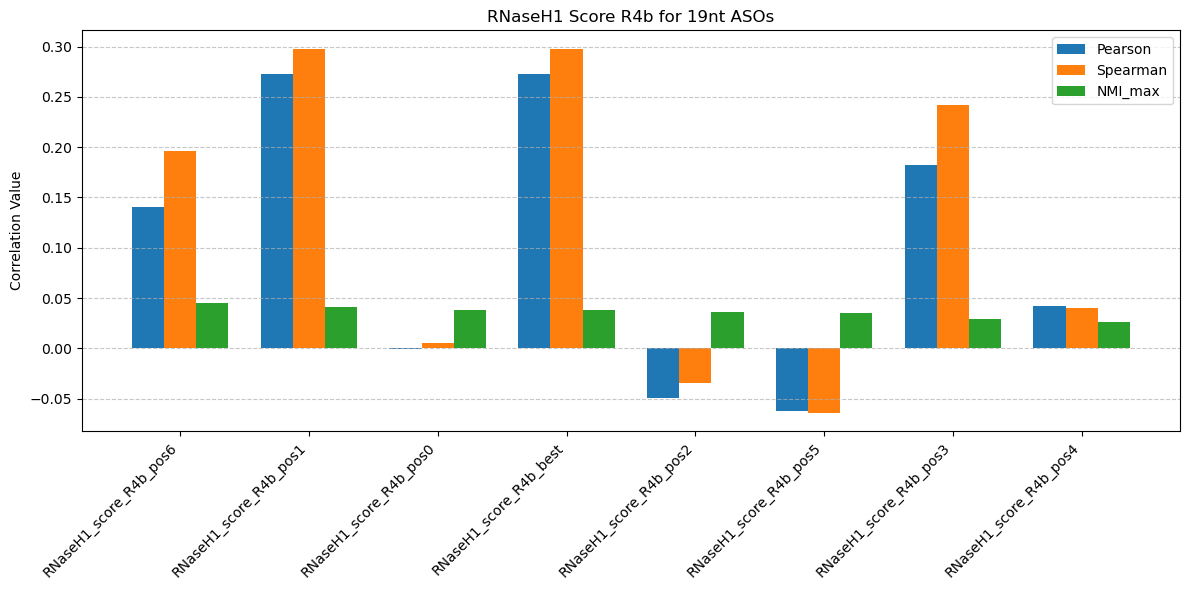

No features found starting with 'RNaseH1_score_R4b'


In [ ]:
plot_feature_correlations_by_prefix(results_df_16, prefix='RNaseH1_score_R4b', title='RNaseH1 Score R4b for 16nt ASOs')
plot_feature_correlations_by_prefix(results_df_17, prefix='RNaseH1_score_R4b', title='RNaseH1 Score R4b for 17nt ASOs')
plot_feature_correlations_by_prefix(results_df_20, prefix='RNaseH1_score_R4b', title='RNaseH1 Score R4b for 20nt ASOs')
plot_feature_correlations_by_prefix(results_df_18, prefix='RNaseH1_score_R4b', title='RNaseH1 Score R4b for 18nt ASOs') 
plot_feature_correlations_by_prefix(results_df_19, prefix='RNaseH1_score_R4b', title='RNaseH1 Score R4b for 19nt ASOs')
plot_feature_correlations_by_prefix(results_df_15, prefix='RNaseH1_score_R4b', title='RNaseH1 Score R4b for 15nt ASOs')


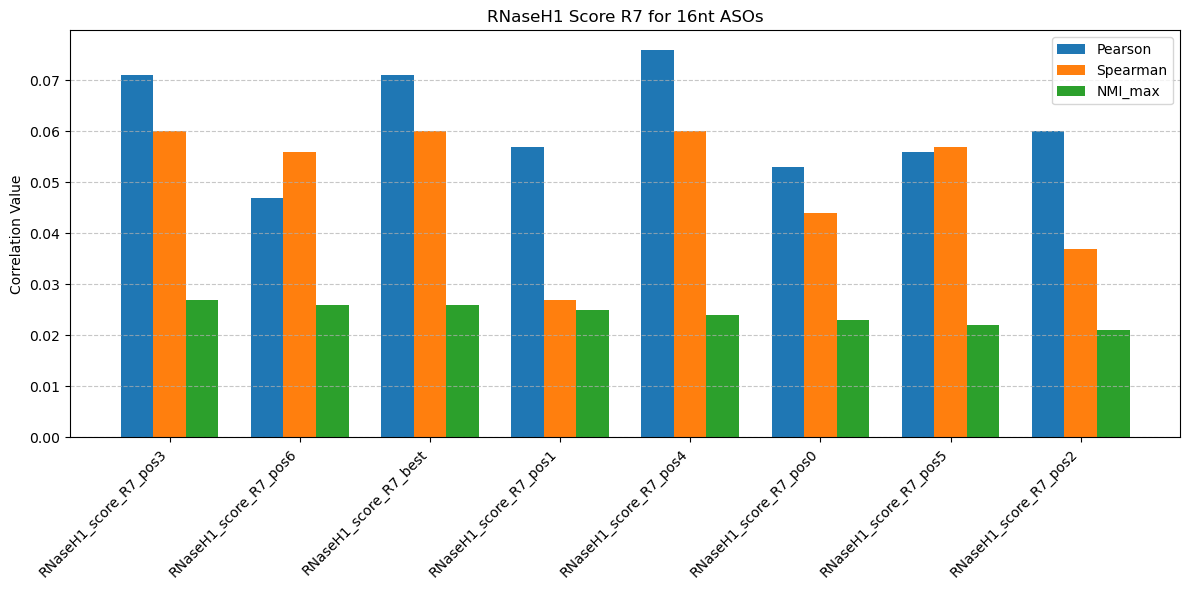

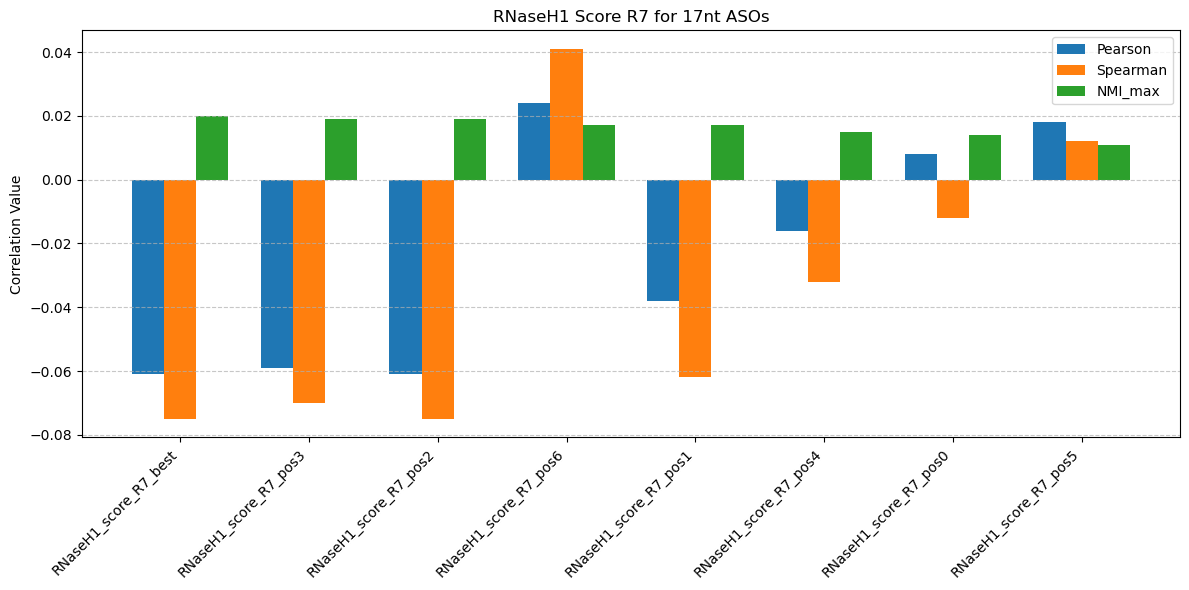

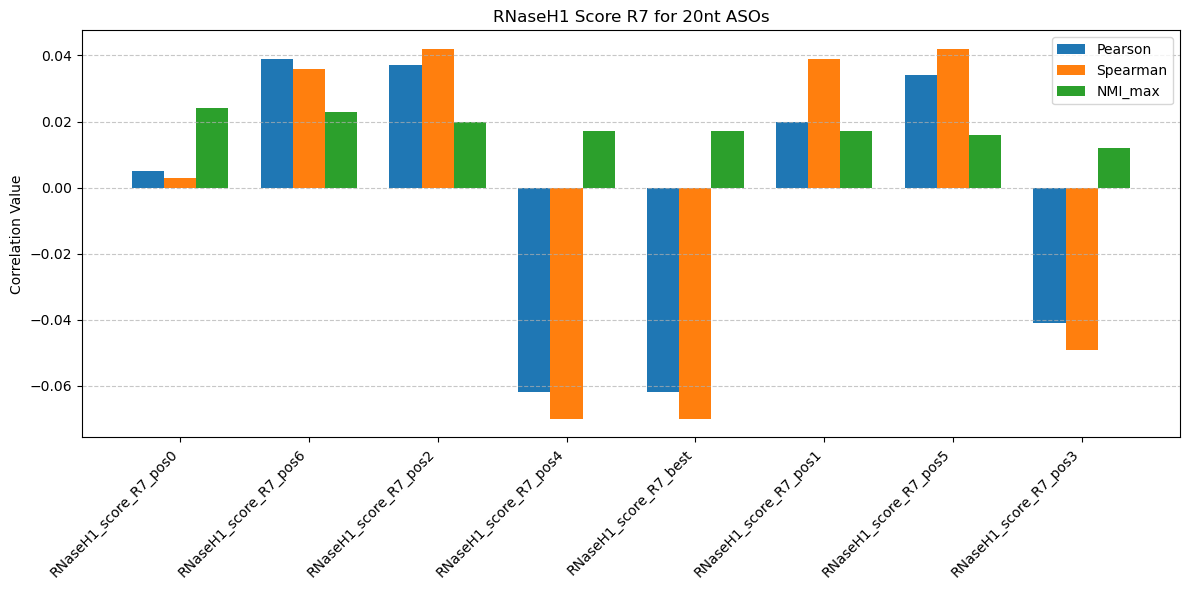

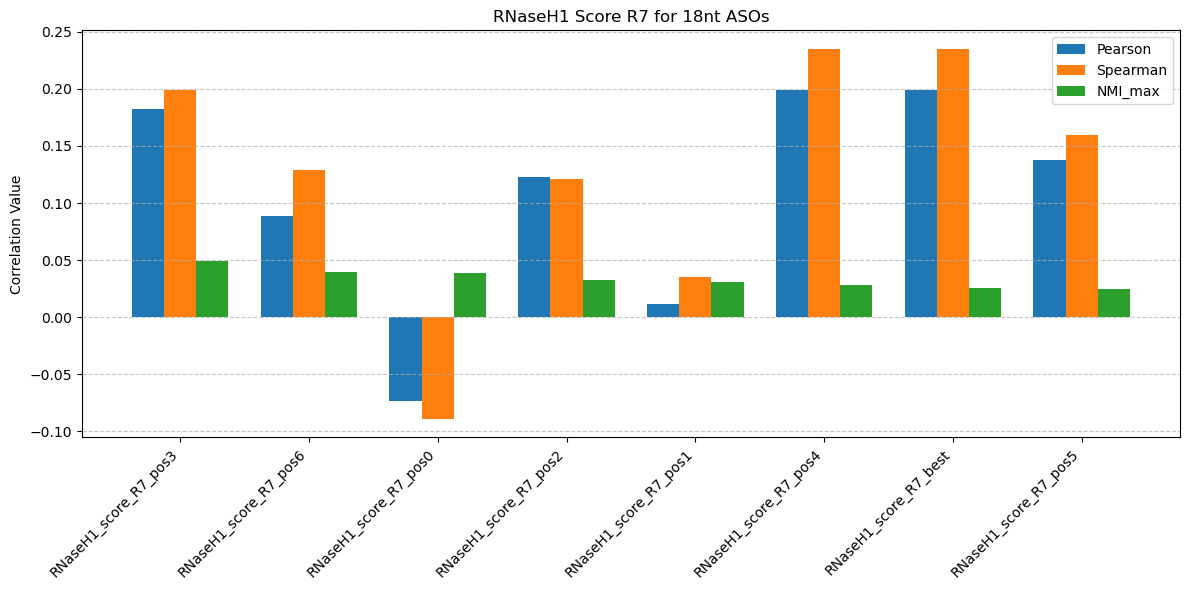

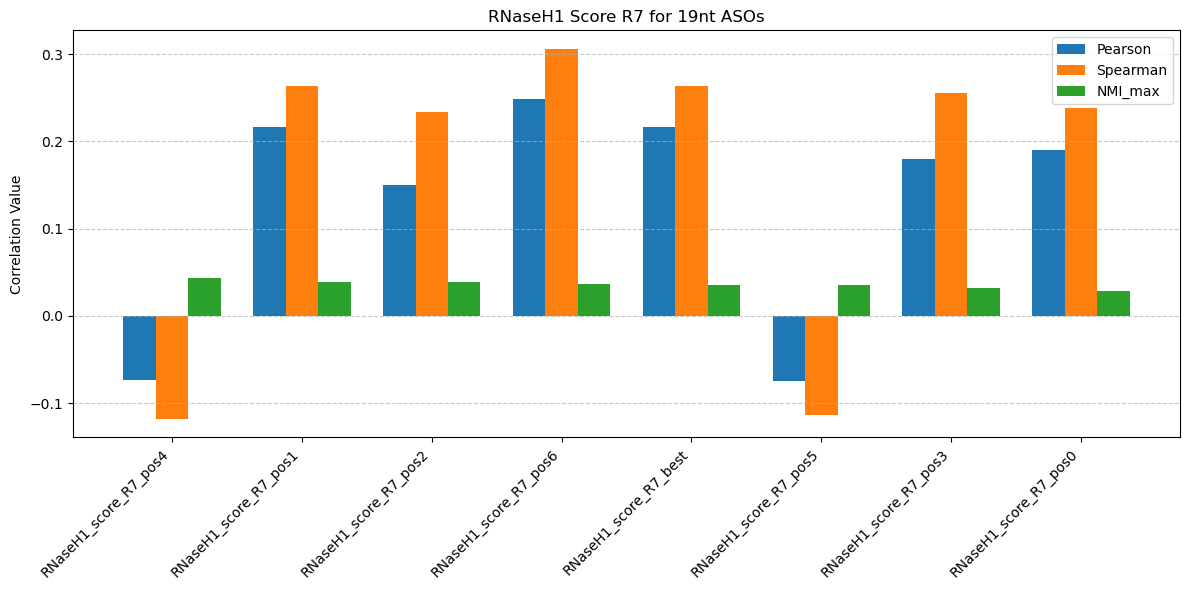

No features found starting with 'RNaseH1_score_R7'


In [140]:
plot_feature_correlations_by_prefix(results_df_16, prefix='RNaseH1_score_R7', title='RNaseH1 Score R7 for 16nt ASOs')
plot_feature_correlations_by_prefix(results_df_17, prefix='RNaseH1_score_R7', title='RNaseH1 Score R7 for 17nt ASOs')
plot_feature_correlations_by_prefix(results_df_20, prefix='RNaseH1_score_R7', title='RNaseH1 Score R7 for 20nt ASOs')
plot_feature_correlations_by_prefix(results_df_18, prefix='RNaseH1_score_R7', title='RNaseH1 Score R7 for 18nt ASOs') 
plot_feature_correlations_by_prefix(results_df_19, prefix='RNaseH1_score_R7', title='RNaseH1 Score R7 for 19nt ASOs')
plot_feature_correlations_by_prefix(results_df_15, prefix='RNaseH1_score_R7', title='RNaseH1 Score R7 for 15nt ASOs')

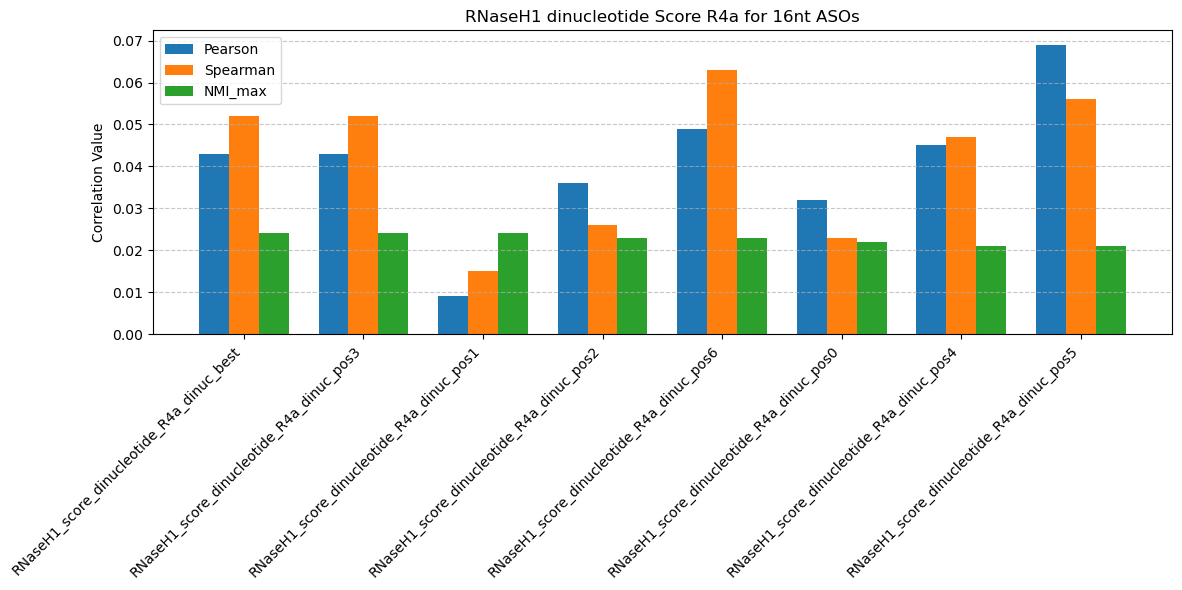

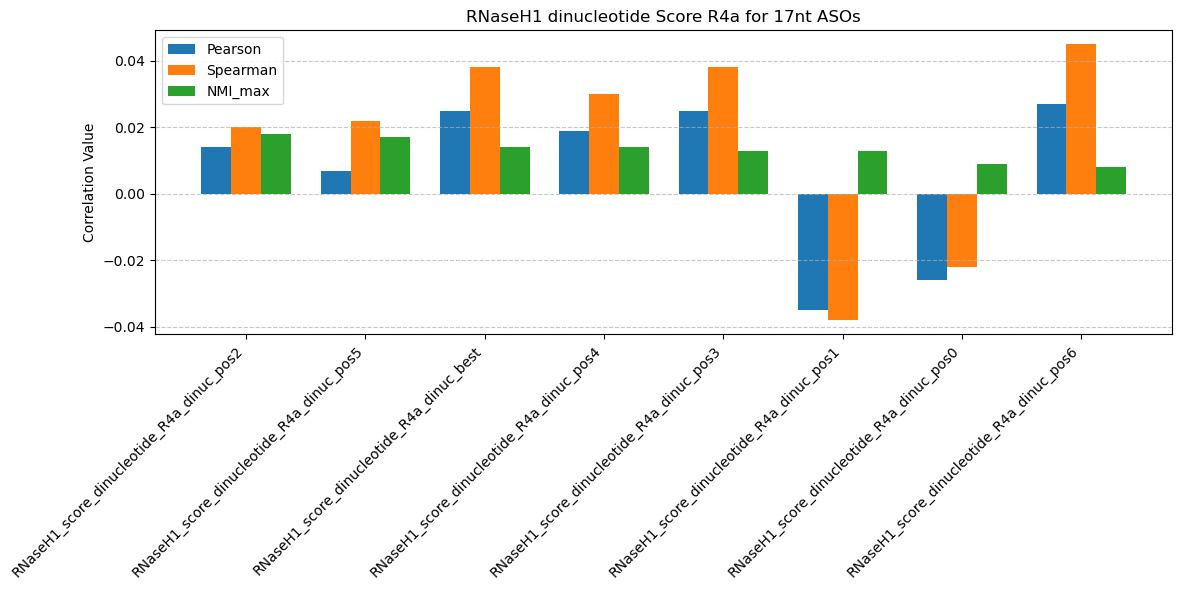

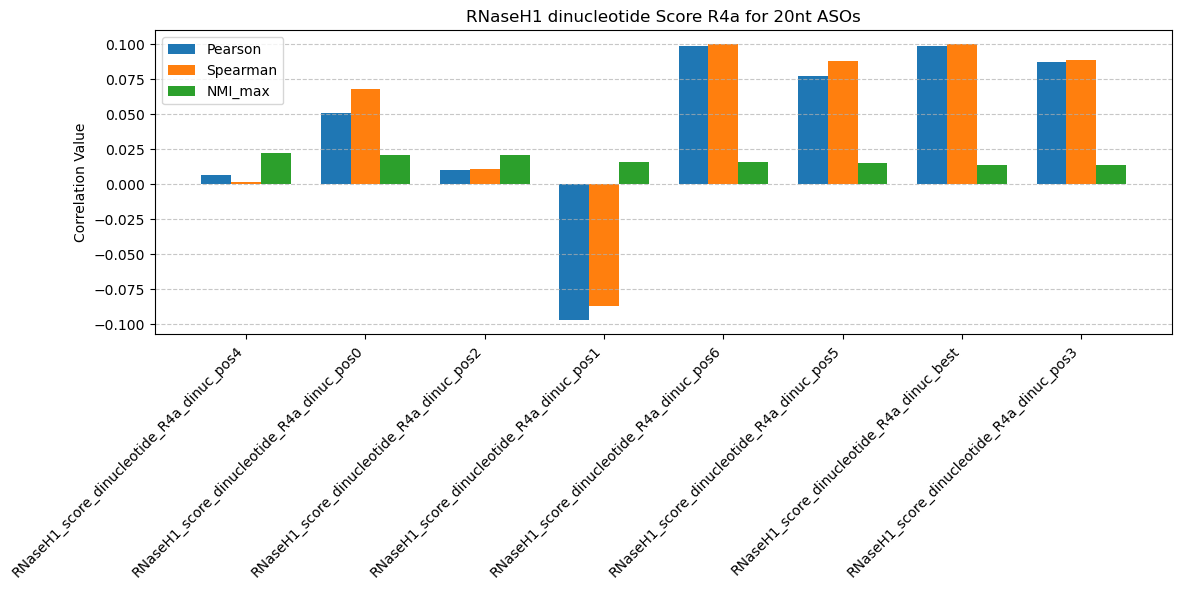

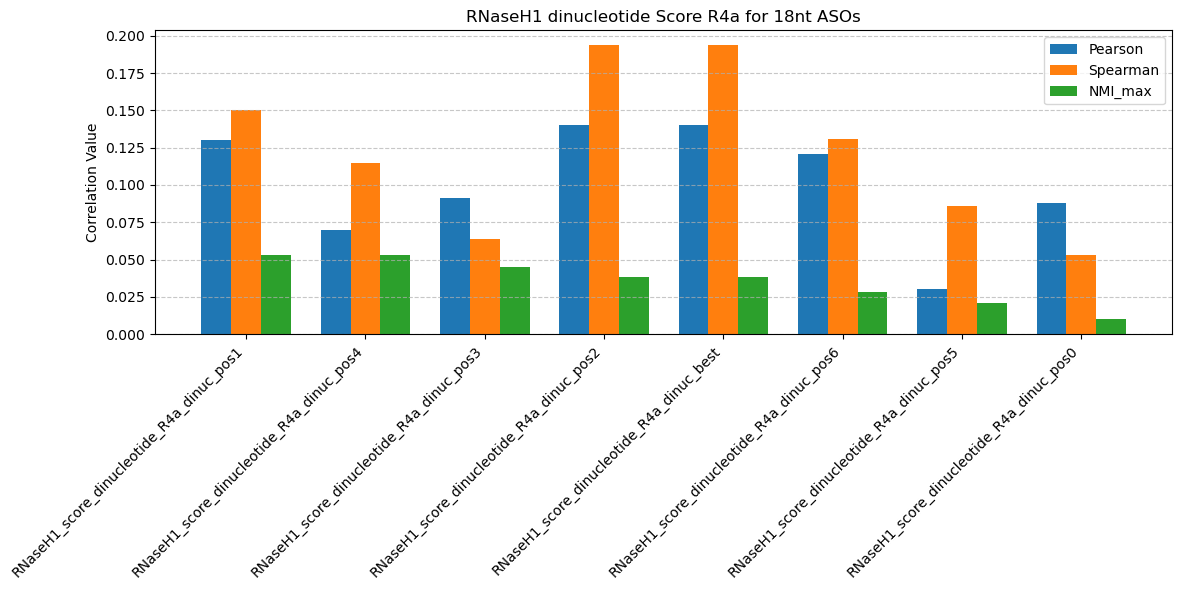

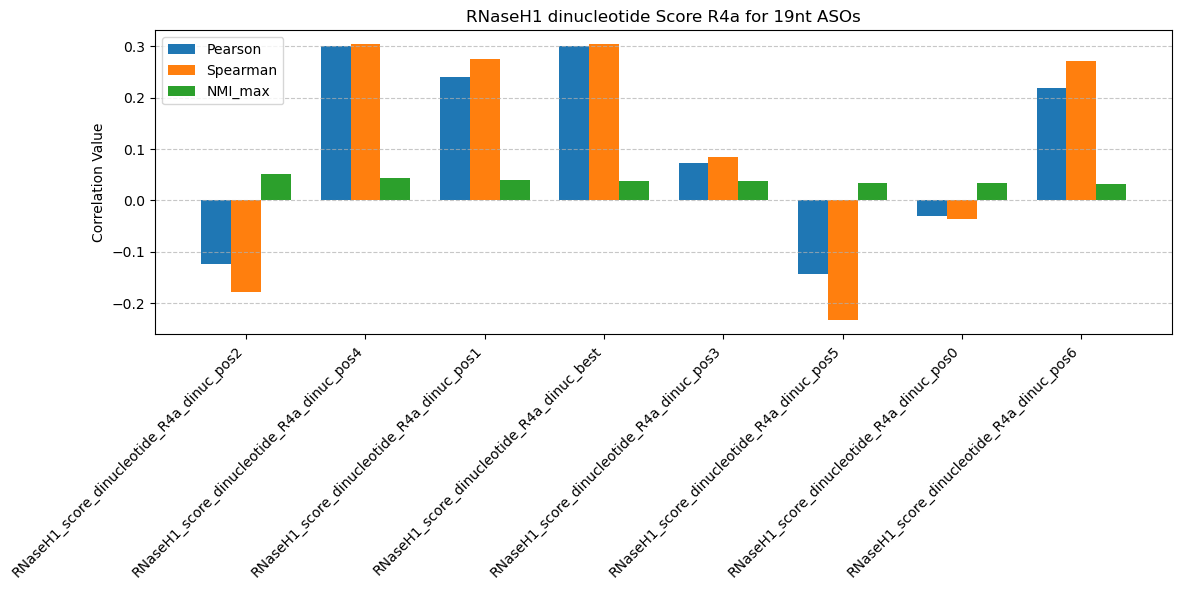

No features found starting with 'RNaseH1_score_dinucleotide_R4a'


In [141]:

plot_feature_correlations_by_prefix(results_df_16, prefix='RNaseH1_score_dinucleotide_R4a', title='RNaseH1 dinucleotide Score R4a for 16nt ASOs')
plot_feature_correlations_by_prefix(results_df_17, prefix='RNaseH1_score_dinucleotide_R4a', title='RNaseH1 dinucleotide Score R4a for 17nt ASOs')
plot_feature_correlations_by_prefix(results_df_20, prefix='RNaseH1_score_dinucleotide_R4a', title='RNaseH1 dinucleotide Score R4a for 20nt ASOs')
plot_feature_correlations_by_prefix(results_df_18, prefix='RNaseH1_score_dinucleotide_R4a', title='RNaseH1 dinucleotide Score R4a for 18nt ASOs') 
plot_feature_correlations_by_prefix(results_df_19, prefix='RNaseH1_score_dinucleotide_R4a', title='RNaseH1 dinucleotide Score R4a for 19nt ASOs')
plot_feature_correlations_by_prefix(results_df_15, prefix='RNaseH1_score_dinucleotide_R4a', title='RNaseH1 dinucleotide Score R4a for 15nt ASOs')




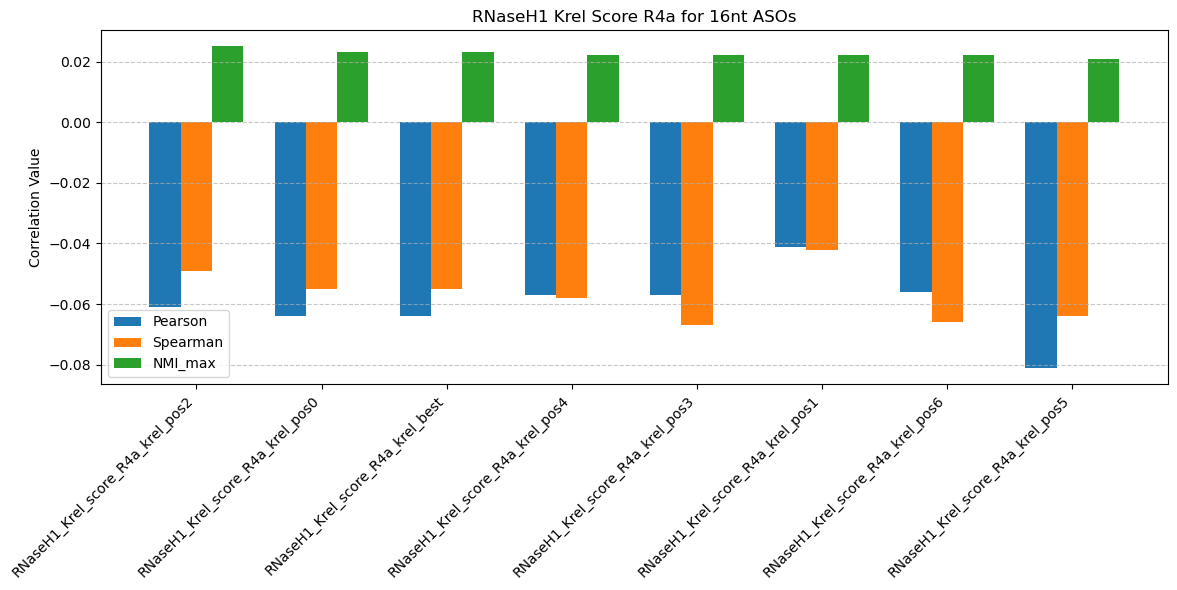

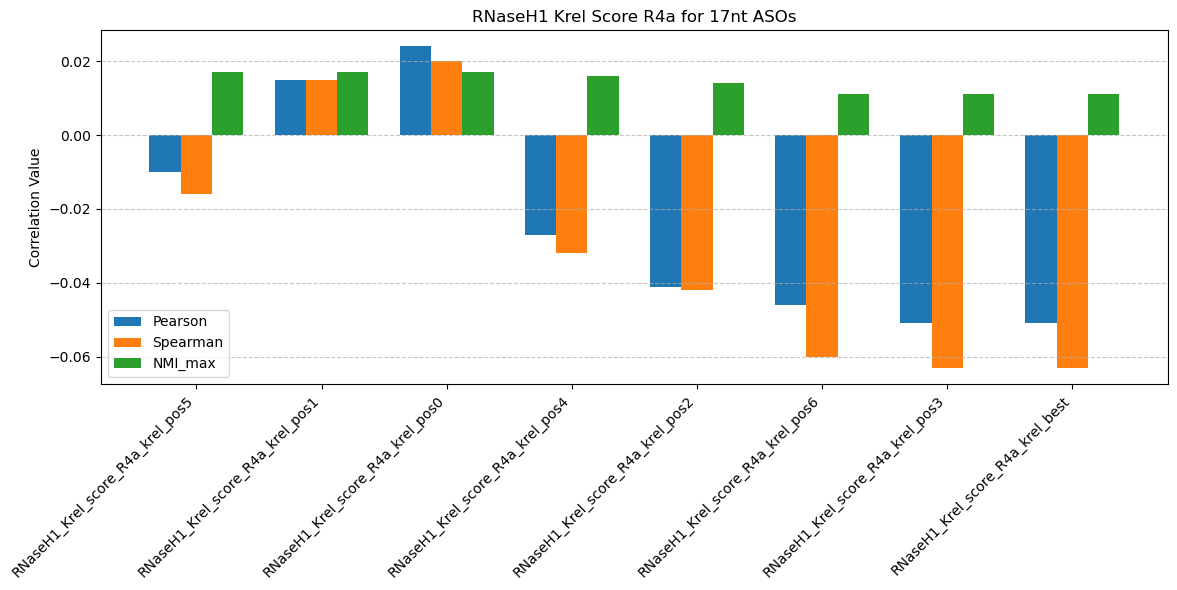

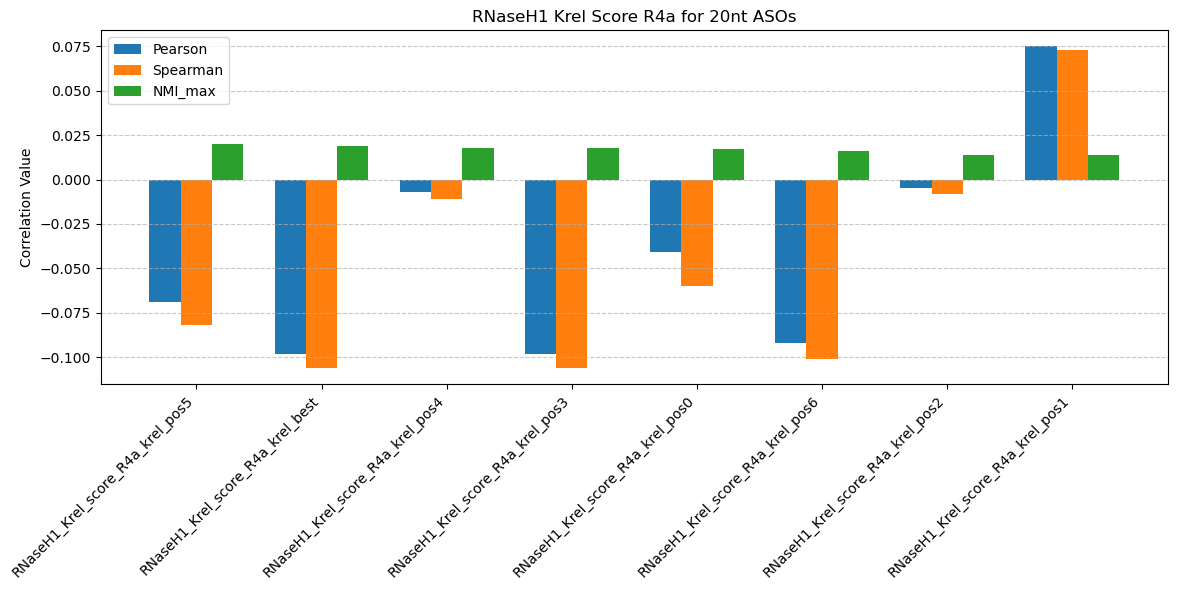

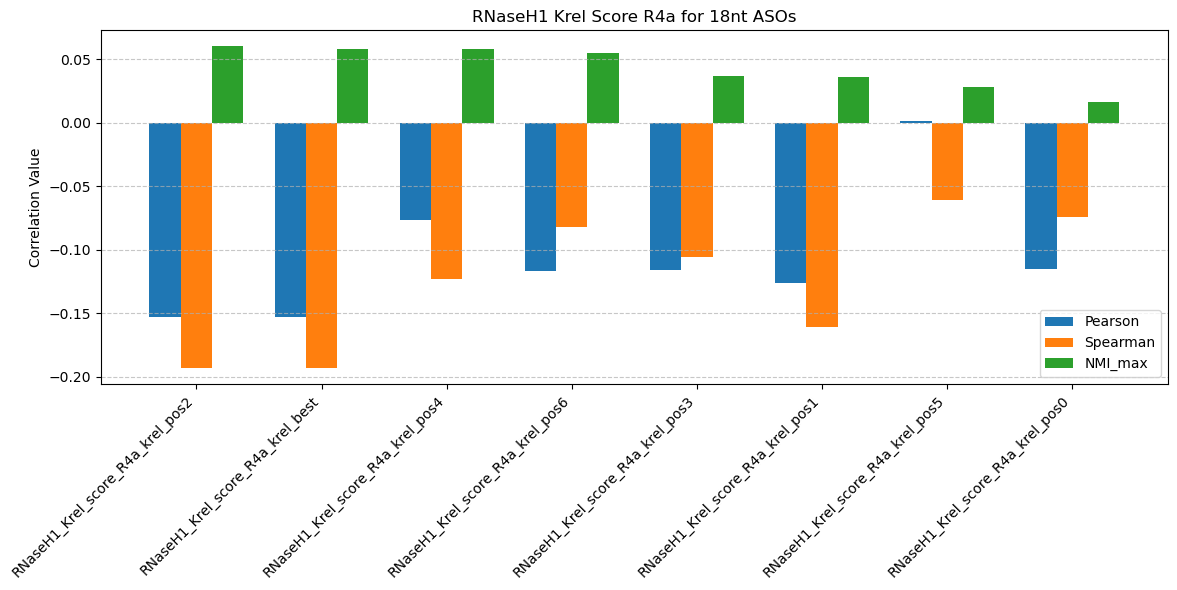

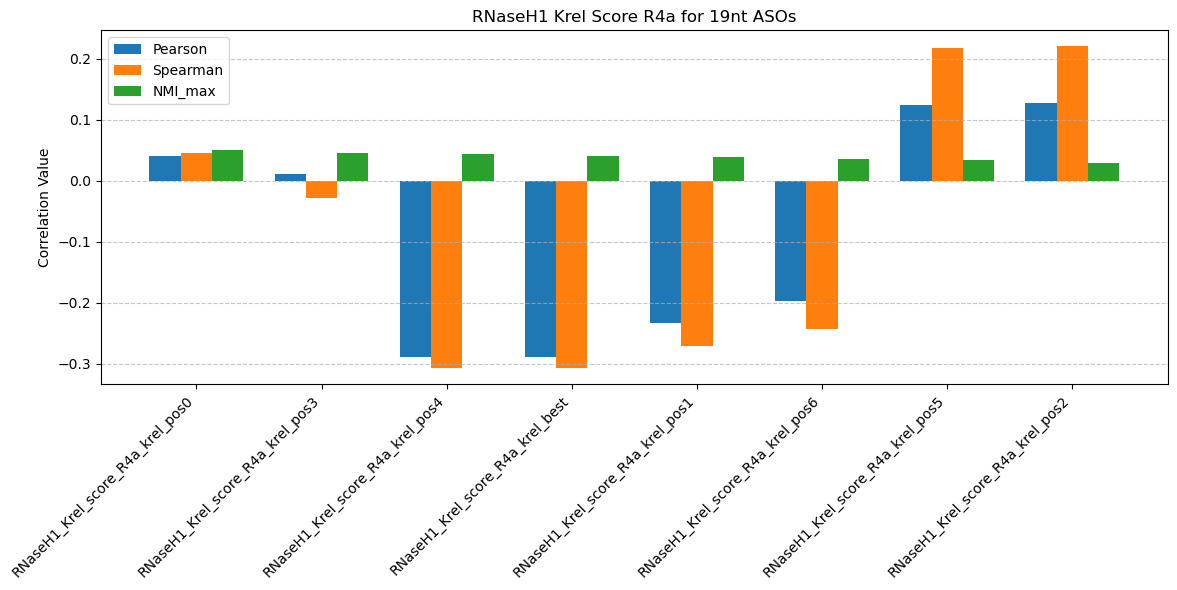

No features found starting with 'RNaseH1_Krel_score_R4a_krel'


In [142]:
plot_feature_correlations_by_prefix(results_df_16, prefix='RNaseH1_Krel_score_R4a_krel', title='RNaseH1 Krel Score R4a for 16nt ASOs')
plot_feature_correlations_by_prefix(results_df_17, prefix='RNaseH1_Krel_score_R4a_krel', title='RNaseH1 Krel Score R4a for 17nt ASOs')
plot_feature_correlations_by_prefix(results_df_20, prefix='RNaseH1_Krel_score_R4a_krel', title='RNaseH1 Krel Score R4a for 20nt ASOs')
plot_feature_correlations_by_prefix(results_df_18, prefix='RNaseH1_Krel_score_R4a_krel', title='RNaseH1 Krel Score R4a for 18nt ASOs') 
plot_feature_correlations_by_prefix(results_df_19, prefix='RNaseH1_Krel_score_R4a_krel', title='RNaseH1 Krel Score R4a for 19nt ASOs')
plot_feature_correlations_by_prefix(results_df_15, prefix='RNaseH1_Krel_score_R4a_krel', title='RNaseH1 Krel Score R4a for 15nt ASOs')


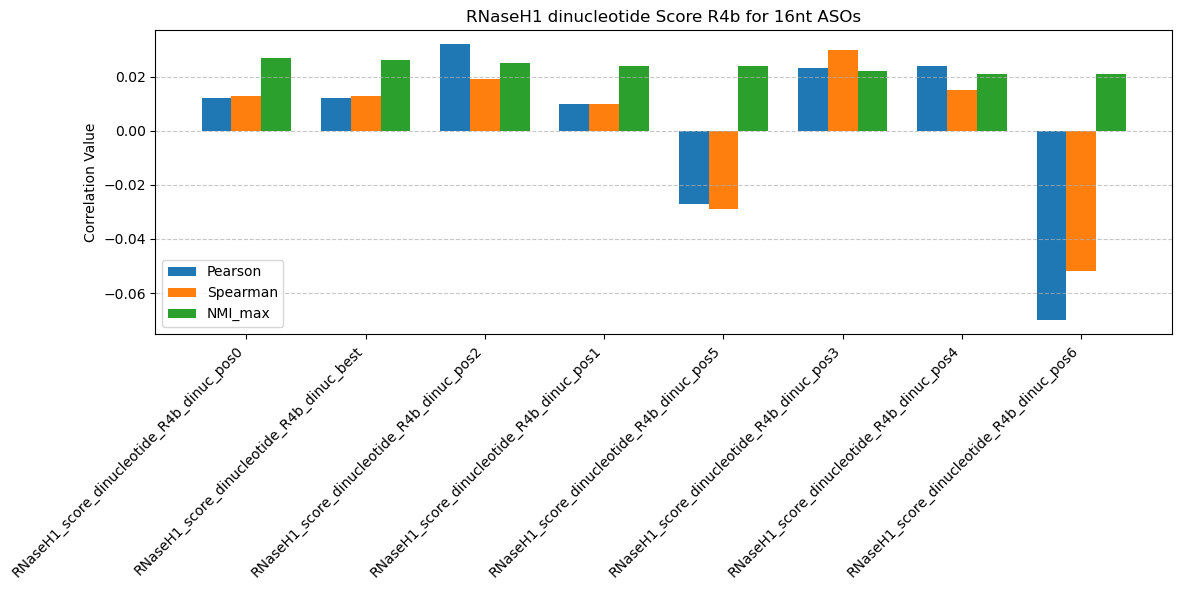

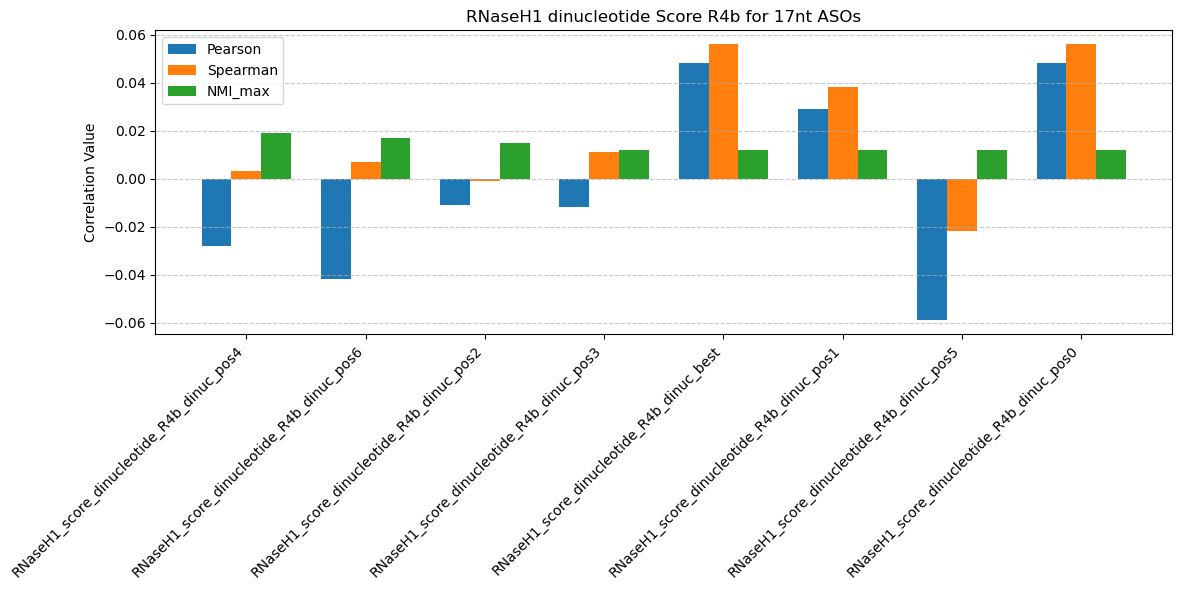

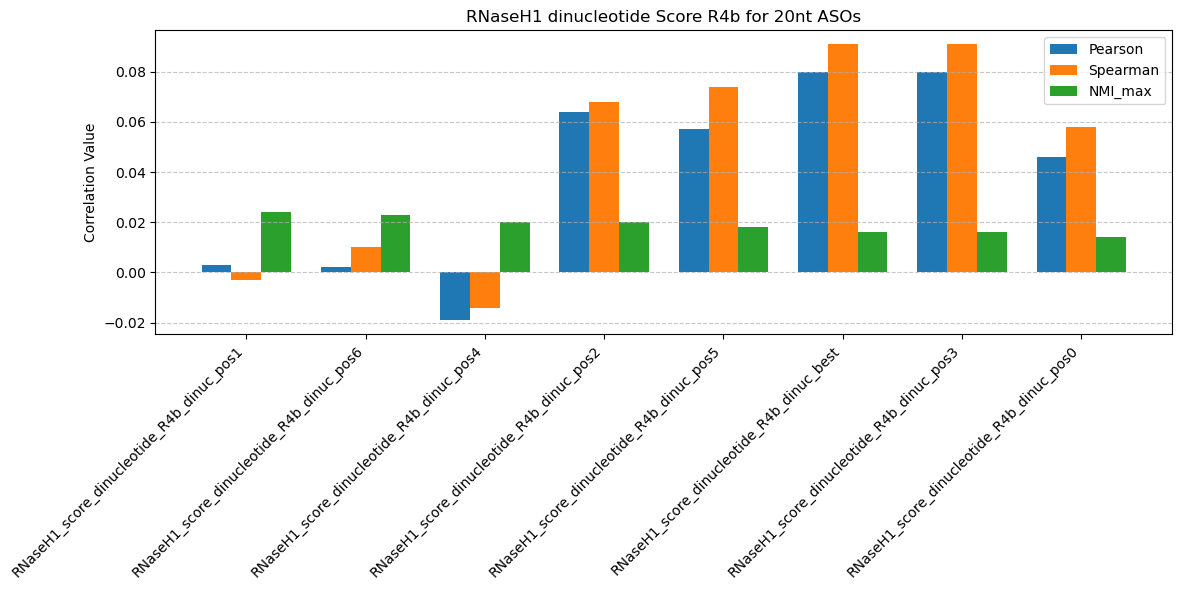

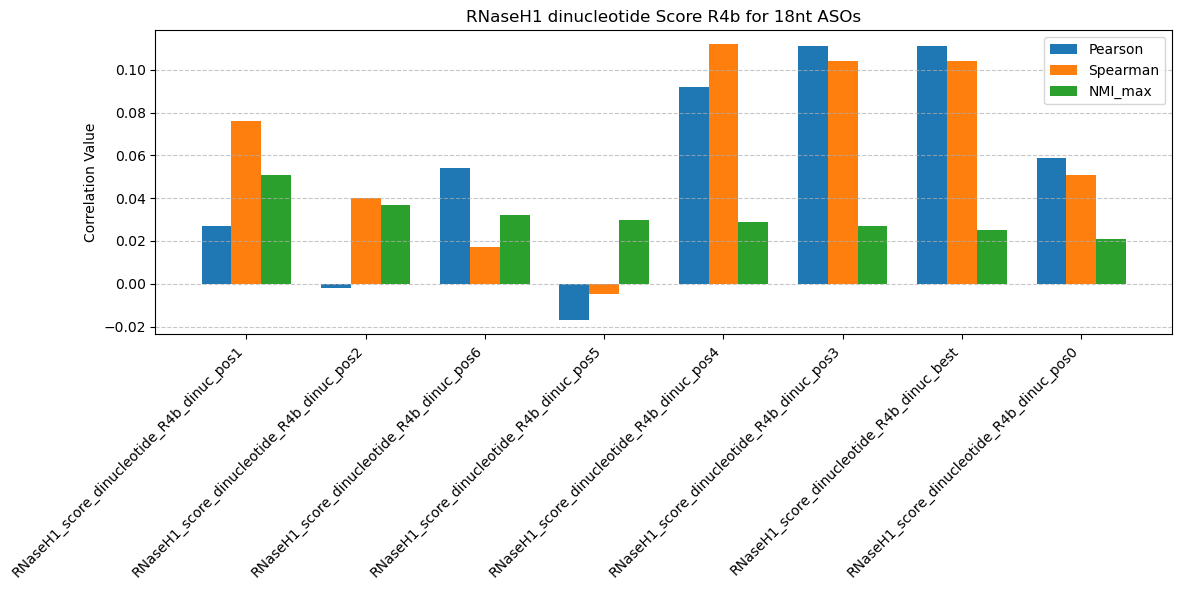

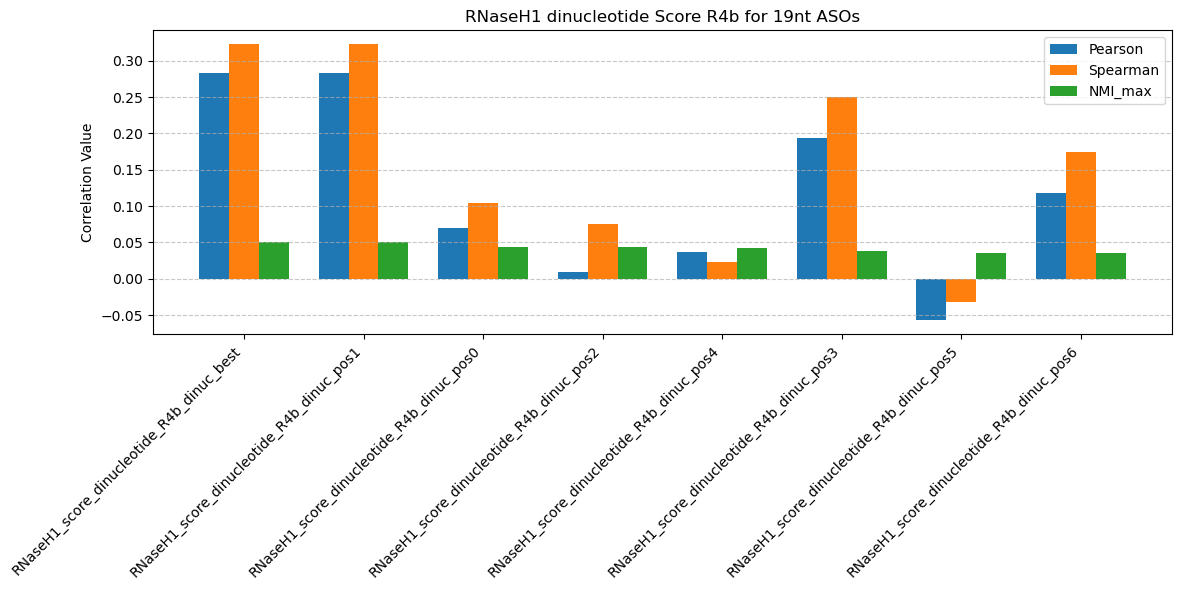

No features found starting with 'RNaseH1_score_dinucleotide_R4b'


In [143]:

plot_feature_correlations_by_prefix(results_df_16, prefix='RNaseH1_score_dinucleotide_R4b', title='RNaseH1 dinucleotide Score R4b for 16nt ASOs')
plot_feature_correlations_by_prefix(results_df_17, prefix='RNaseH1_score_dinucleotide_R4b', title='RNaseH1 dinucleotide Score R4b for 17nt ASOs')
plot_feature_correlations_by_prefix(results_df_20, prefix='RNaseH1_score_dinucleotide_R4b', title='RNaseH1 dinucleotide Score R4b for 20nt ASOs')
plot_feature_correlations_by_prefix(results_df_18, prefix='RNaseH1_score_dinucleotide_R4b', title='RNaseH1 dinucleotide Score R4b for 18nt ASOs') 
plot_feature_correlations_by_prefix(results_df_19, prefix='RNaseH1_score_dinucleotide_R4b', title='RNaseH1 dinucleotide Score R4b for 19nt ASOs')
plot_feature_correlations_by_prefix(results_df_15, prefix='RNaseH1_score_dinucleotide_R4b', title='RNaseH1 dinucleotide Score R4b for 15nt ASOs')

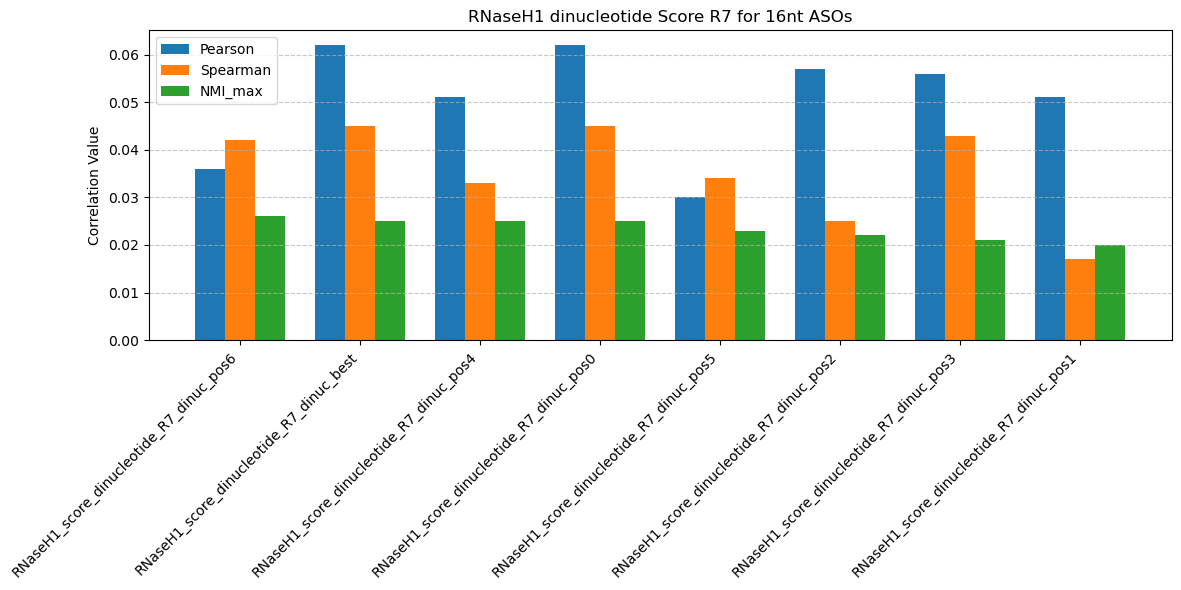

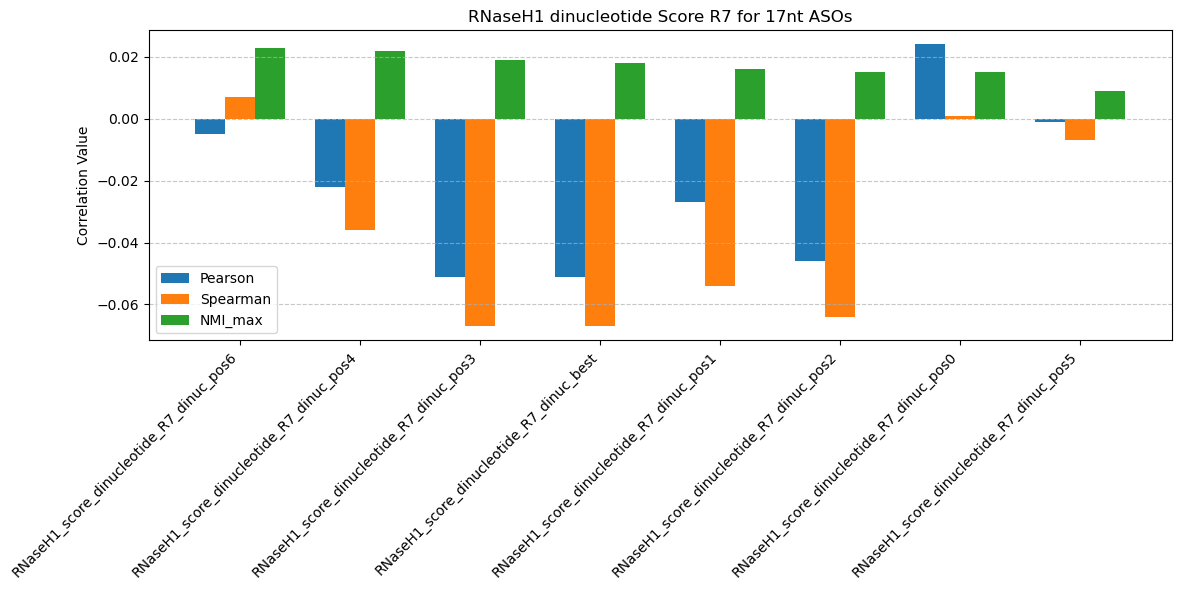

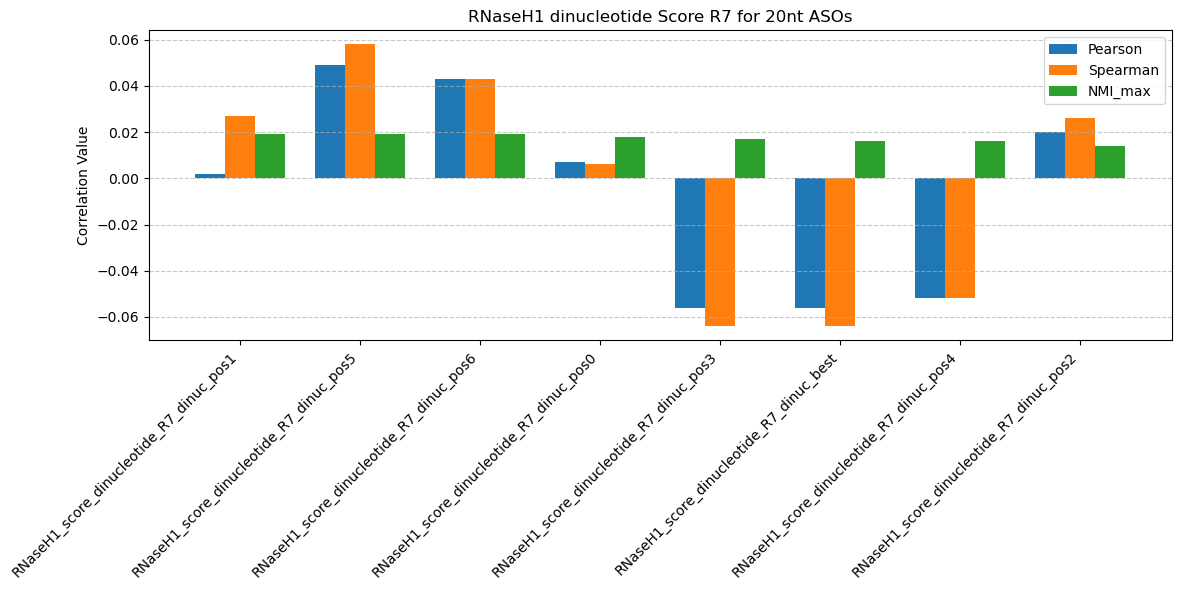

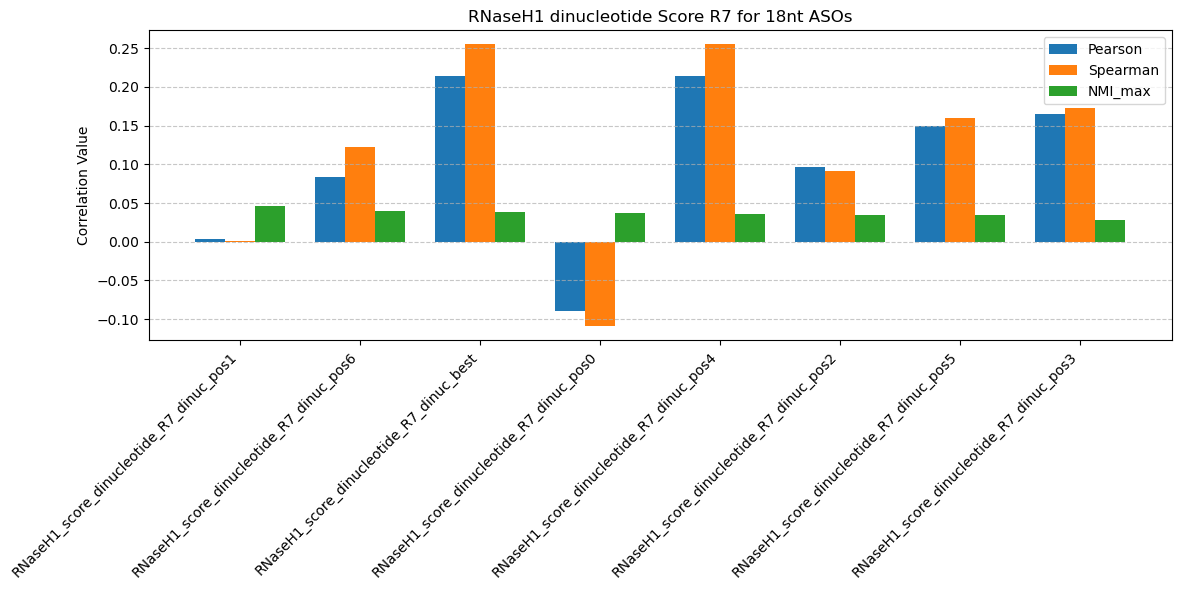

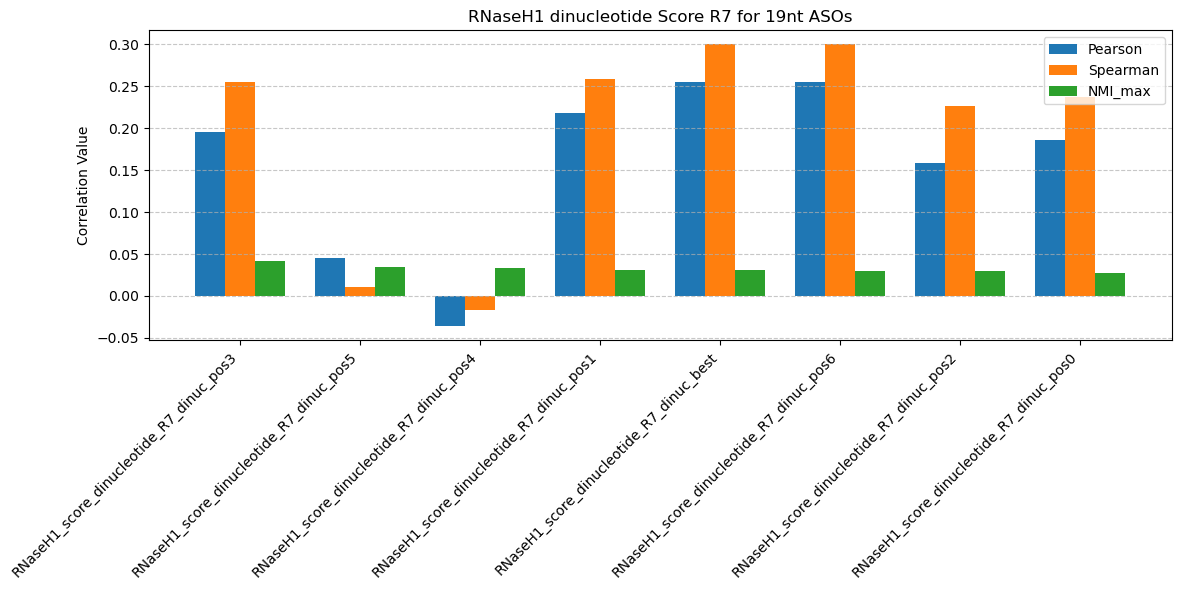

No features found starting with 'RNaseH1_score_dinucleotide_R7'


In [144]:
plot_feature_correlations_by_prefix(results_df_16, prefix='RNaseH1_score_dinucleotide_R7', title='RNaseH1 dinucleotide Score R7 for 16nt ASOs')
plot_feature_correlations_by_prefix(results_df_17, prefix='RNaseH1_score_dinucleotide_R7', title='RNaseH1 dinucleotide Score R7 for 17nt ASOs')
plot_feature_correlations_by_prefix(results_df_20, prefix='RNaseH1_score_dinucleotide_R7', title='RNaseH1 dinucleotide Score R7 for 20nt ASOs')
plot_feature_correlations_by_prefix(results_df_18, prefix='RNaseH1_score_dinucleotide_R7', title='RNaseH1 dinucleotide Score R7 for 18nt ASOs') 
plot_feature_correlations_by_prefix(results_df_19, prefix='RNaseH1_score_dinucleotide_R7', title='RNaseH1 dinucleotide Score R7 for 19nt ASOs')
plot_feature_correlations_by_prefix(results_df_15, prefix='RNaseH1_score_dinucleotide_R7', title='RNaseH1 dinucleotide Score R7 for 15nt ASOs')

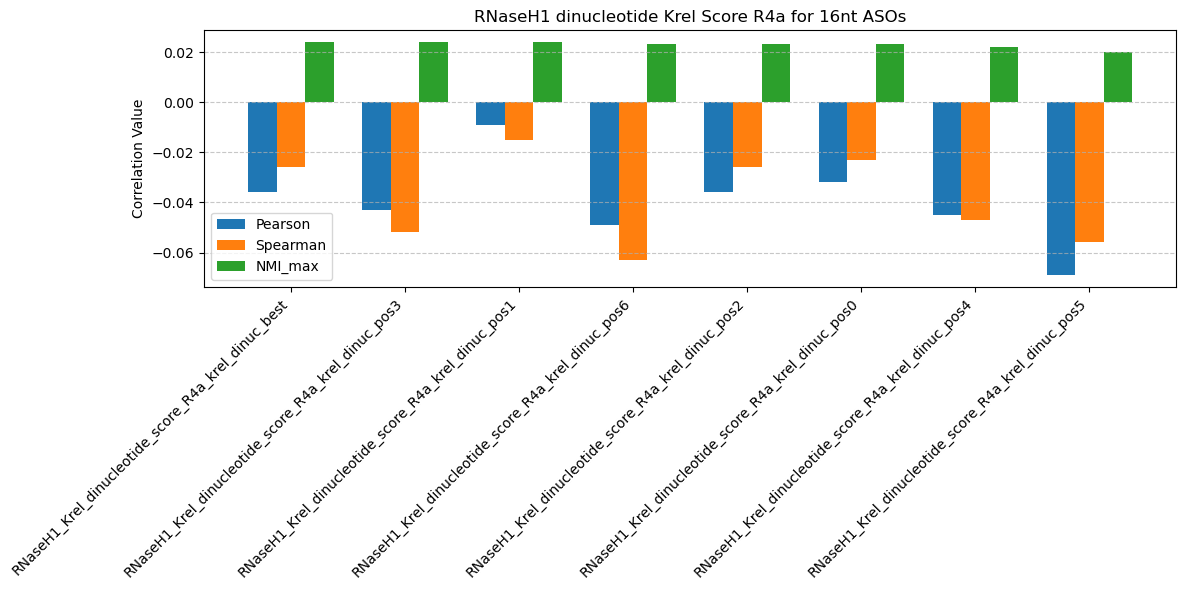

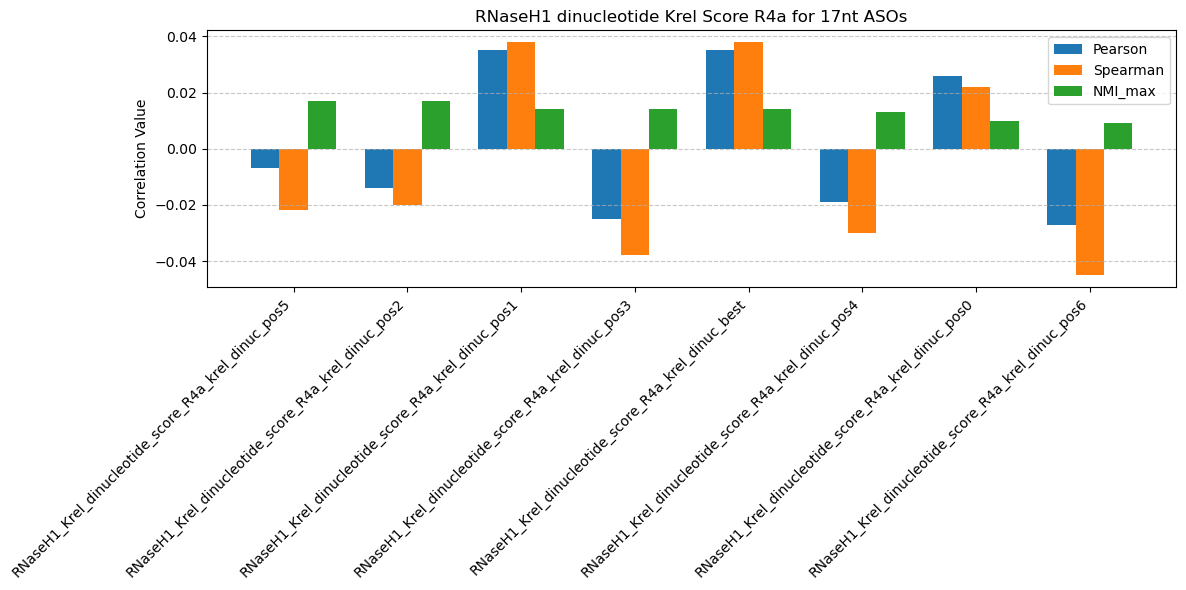

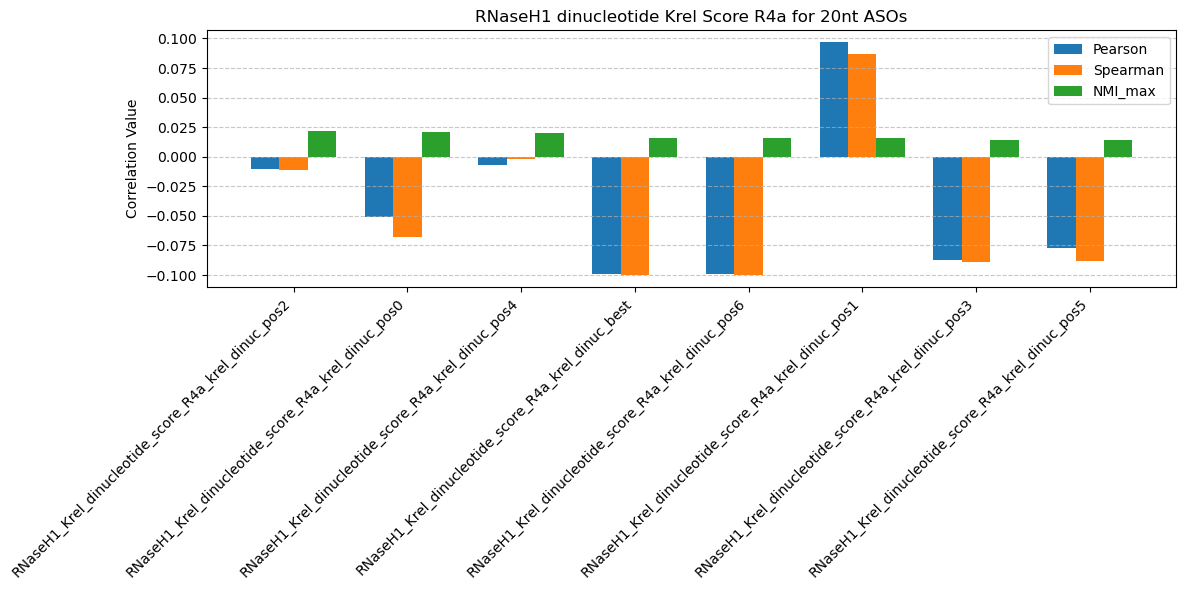

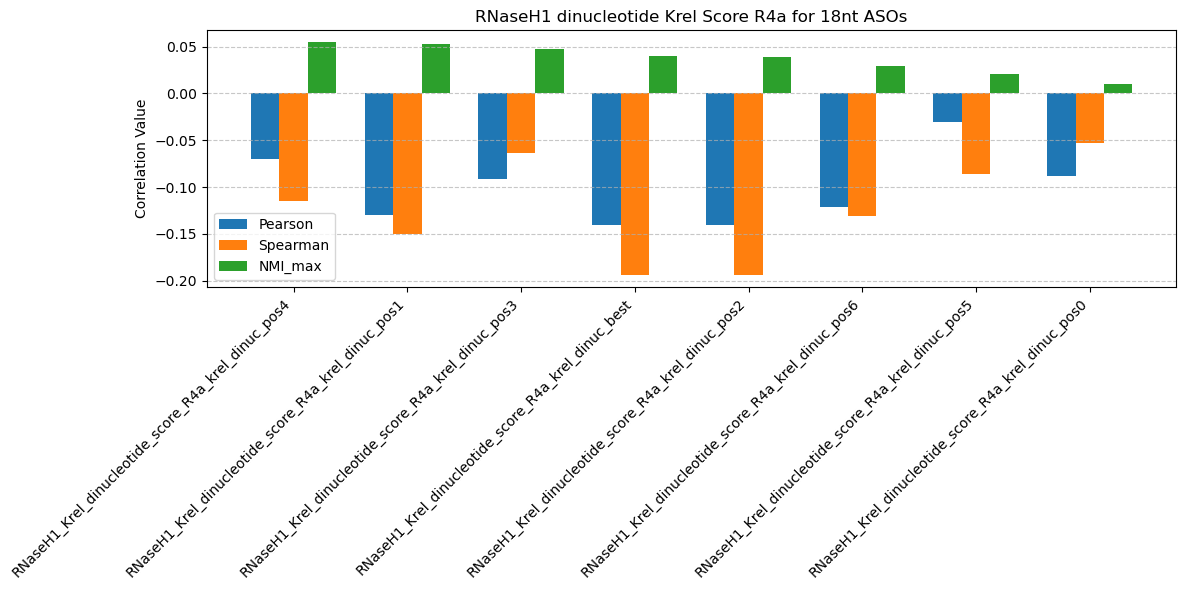

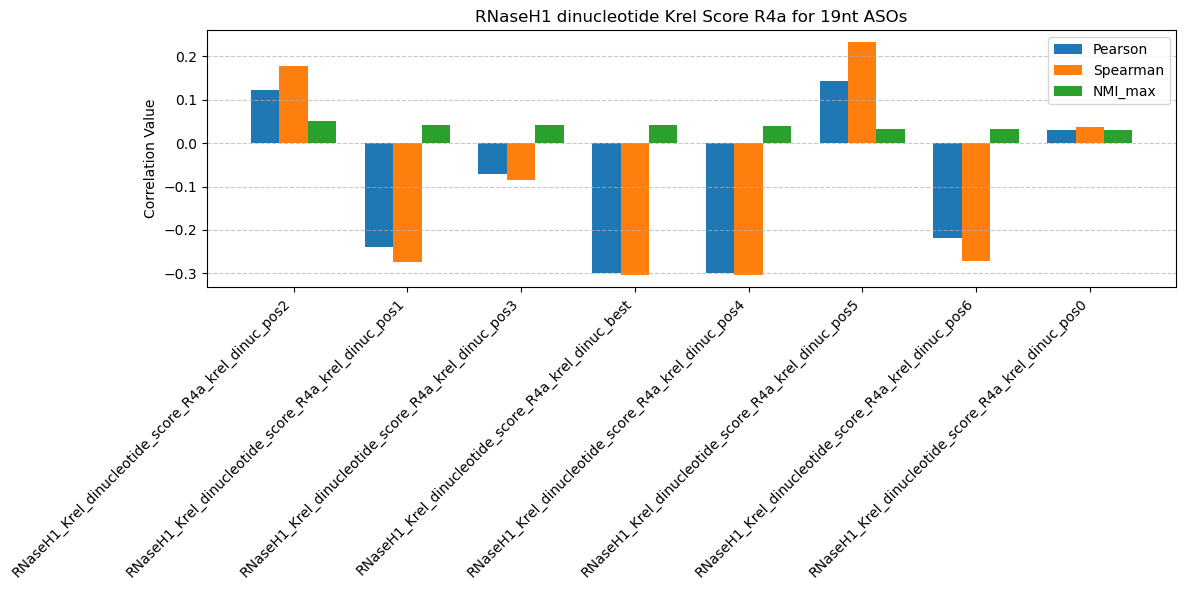

No features found starting with 'RNaseH1_Krel_dinucleotide_score_R4a_krel'


In [145]:
plot_feature_correlations_by_prefix(results_df_16, prefix='RNaseH1_Krel_dinucleotide_score_R4a_krel', title='RNaseH1 dinucleotide Krel Score R4a for 16nt ASOs')
plot_feature_correlations_by_prefix(results_df_17, prefix='RNaseH1_Krel_dinucleotide_score_R4a_krel', title='RNaseH1 dinucleotide Krel Score R4a for 17nt ASOs')
plot_feature_correlations_by_prefix(results_df_20, prefix='RNaseH1_Krel_dinucleotide_score_R4a_krel', title='RNaseH1 dinucleotide Krel Score R4a for 20nt ASOs')
plot_feature_correlations_by_prefix(results_df_18, prefix='RNaseH1_Krel_dinucleotide_score_R4a_krel', title='RNaseH1 dinucleotide Krel Score R4a for 18nt ASOs') 
plot_feature_correlations_by_prefix(results_df_19, prefix='RNaseH1_Krel_dinucleotide_score_R4a_krel', title='RNaseH1 dinucleotide Krel Score R4a for 19nt ASOs')
plot_feature_correlations_by_prefix(results_df_15, prefix='RNaseH1_Krel_dinucleotide_score_R4a_krel', title='RNaseH1 dinucleotide Krel Score R4a for 15nt ASOs')

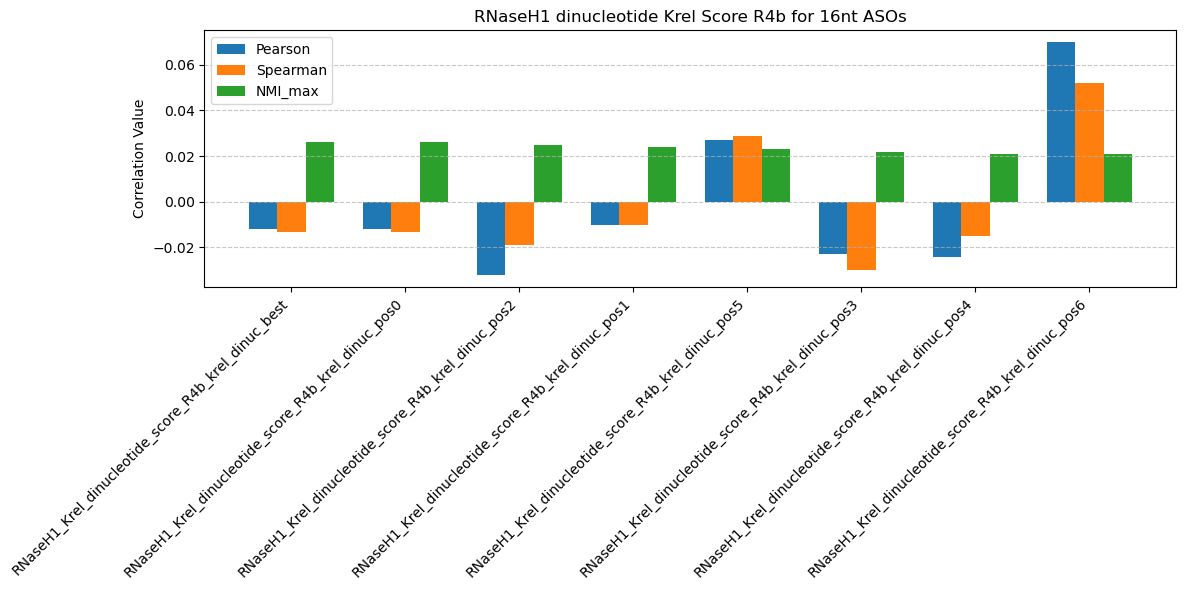

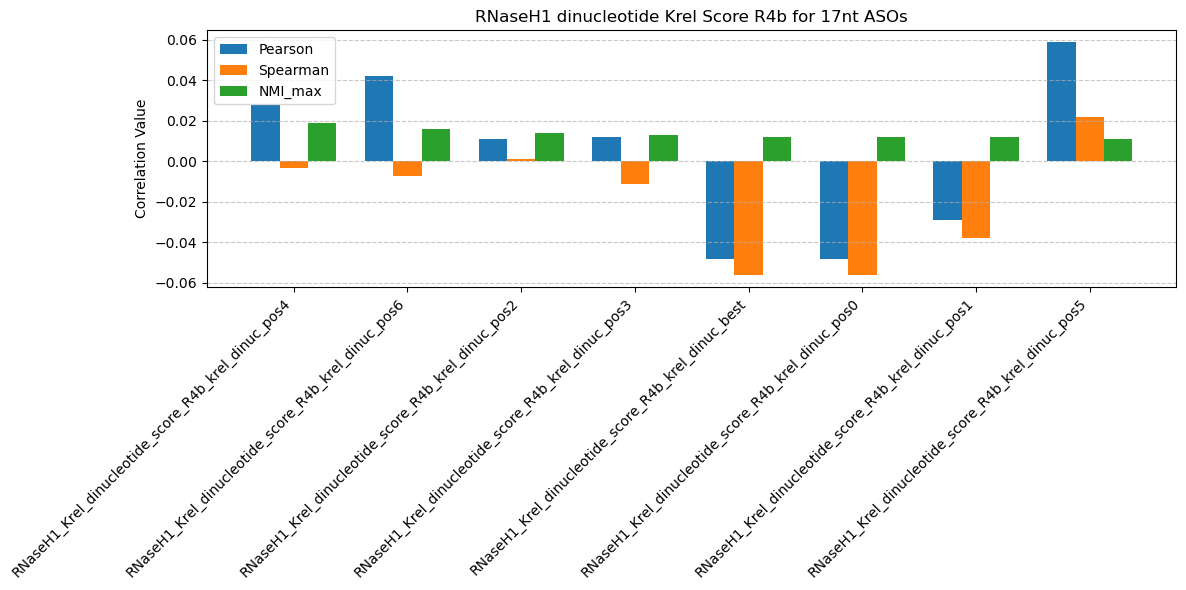

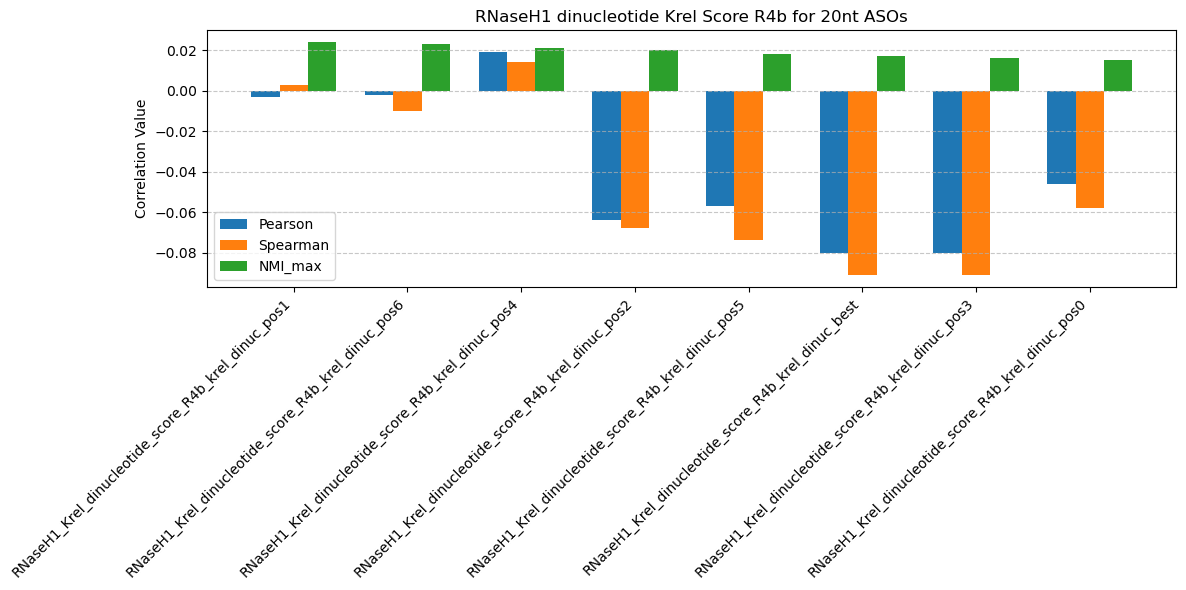

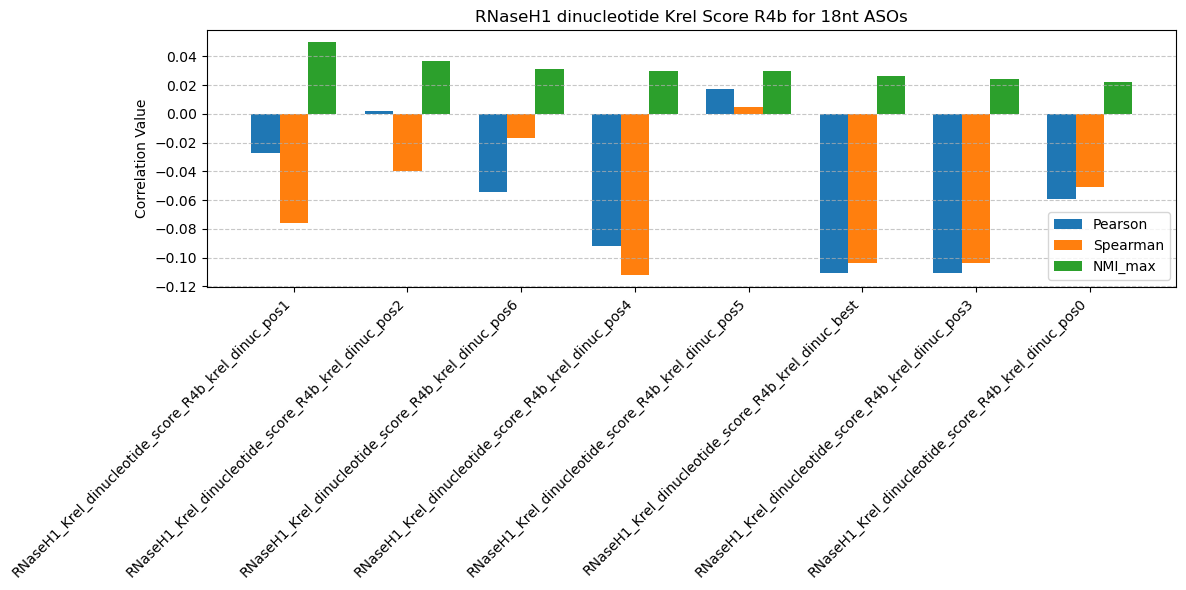

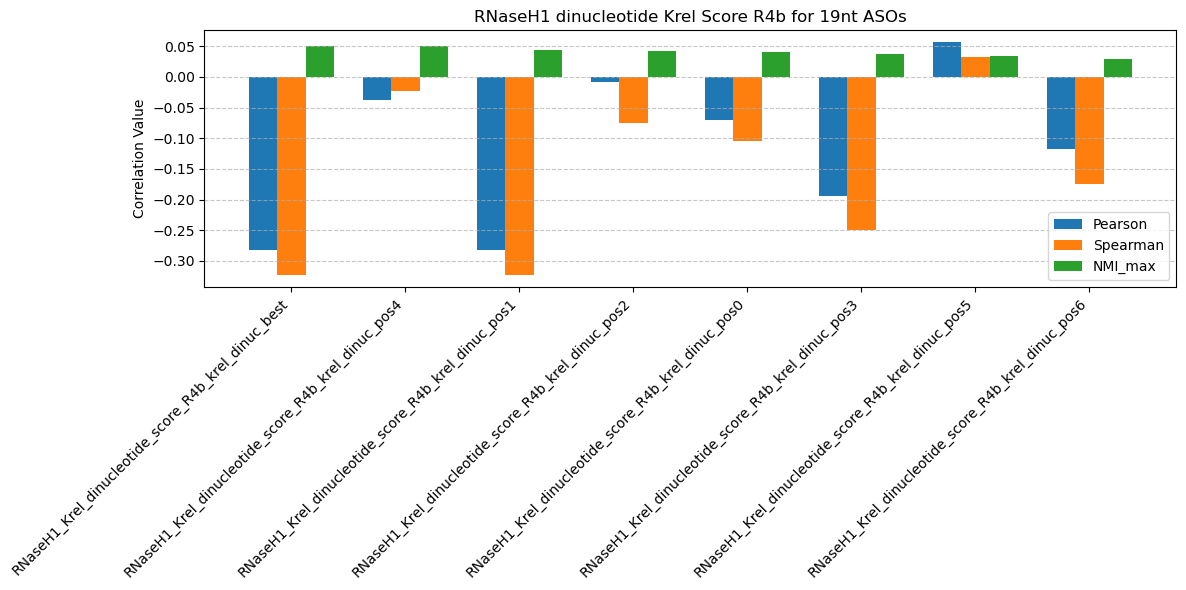

No features found starting with 'RNaseH1_Krel_dinucleotide_score_R4b_krel'


In [146]:
plot_feature_correlations_by_prefix(results_df_16, prefix='RNaseH1_Krel_dinucleotide_score_R4b_krel', title='RNaseH1 dinucleotide Krel Score R4b for 16nt ASOs')
plot_feature_correlations_by_prefix(results_df_17, prefix='RNaseH1_Krel_dinucleotide_score_R4b_krel', title='RNaseH1 dinucleotide Krel Score R4b for 17nt ASOs')
plot_feature_correlations_by_prefix(results_df_20, prefix='RNaseH1_Krel_dinucleotide_score_R4b_krel', title='RNaseH1 dinucleotide Krel Score R4b for 20nt ASOs')
plot_feature_correlations_by_prefix(results_df_18, prefix='RNaseH1_Krel_dinucleotide_score_R4b_krel', title='RNaseH1 dinucleotide Krel Score R4b for 18nt ASOs') 
plot_feature_correlations_by_prefix(results_df_19, prefix='RNaseH1_Krel_dinucleotide_score_R4b_krel', title='RNaseH1 dinucleotide Krel Score R4b for 19nt ASOs')
plot_feature_correlations_by_prefix(results_df_15, prefix='RNaseH1_Krel_dinucleotide_score_R4b_krel', title='RNaseH1 dinucleotide Krel Score R4b for 15nt ASOs')

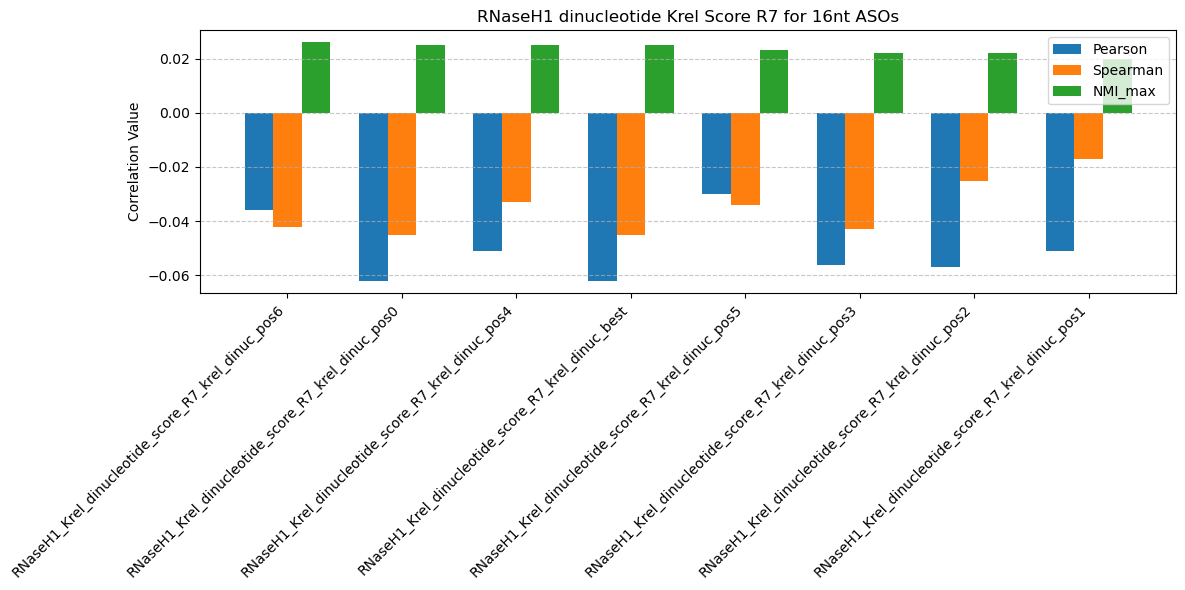

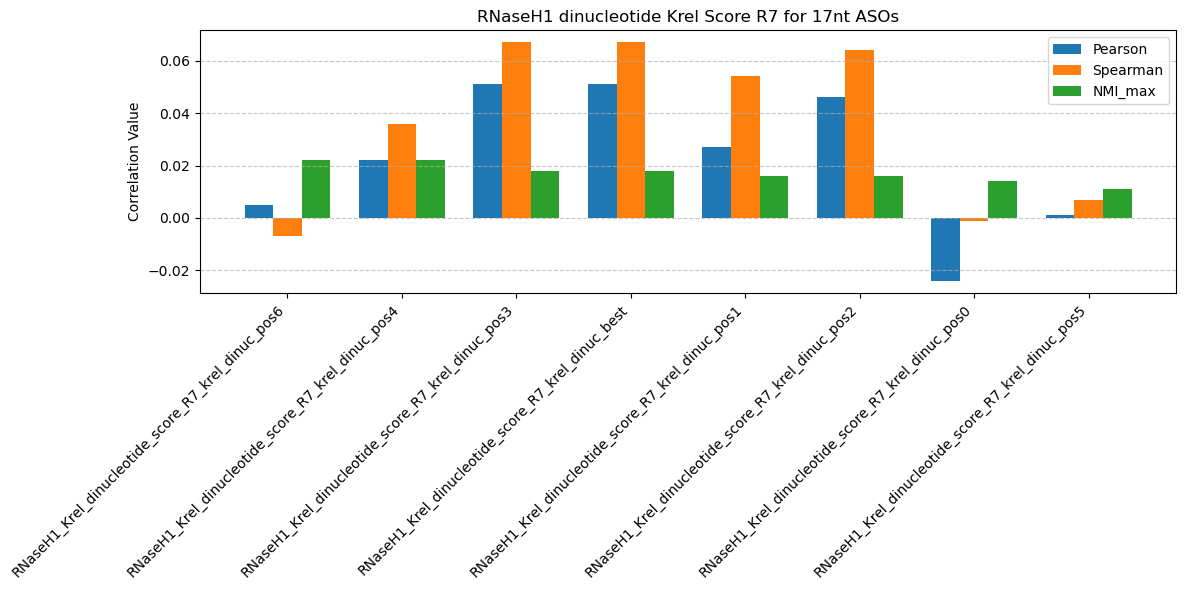

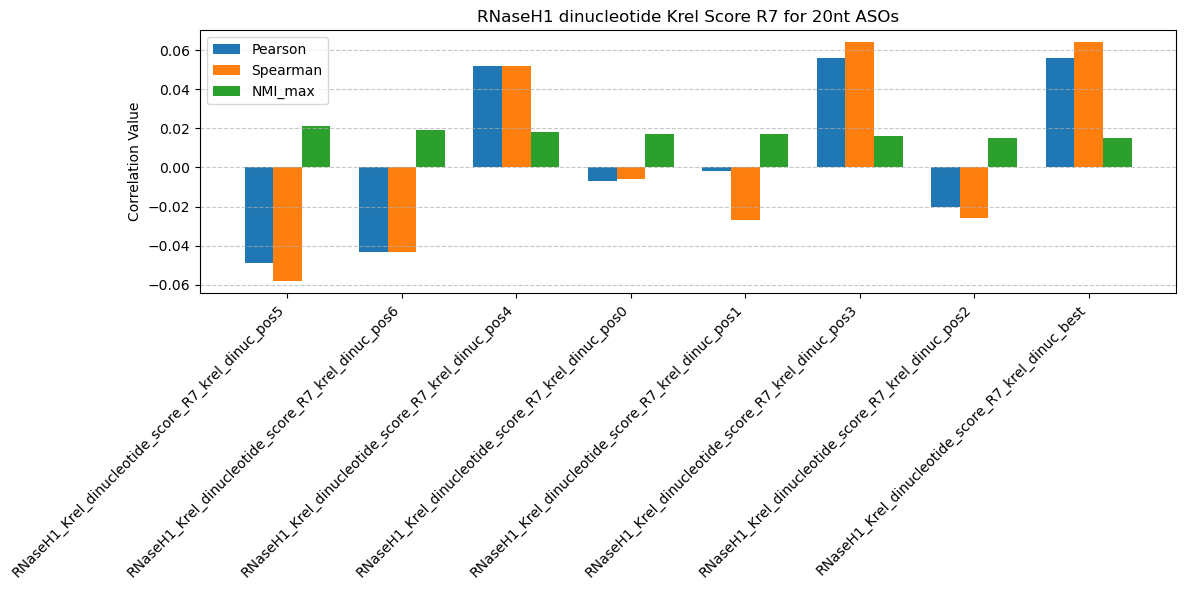

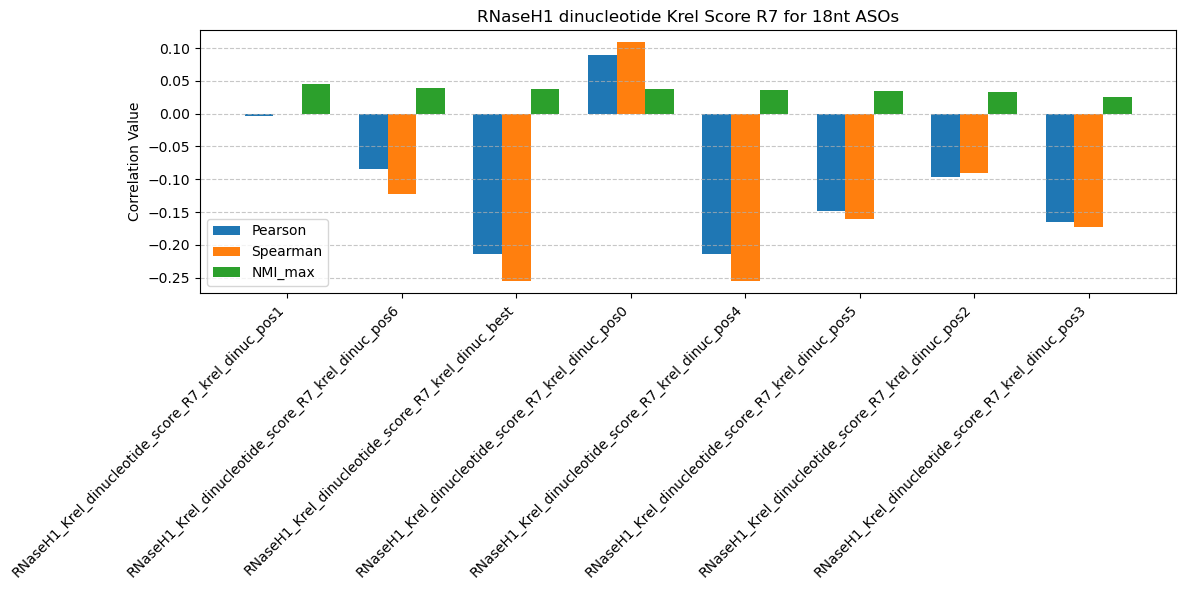

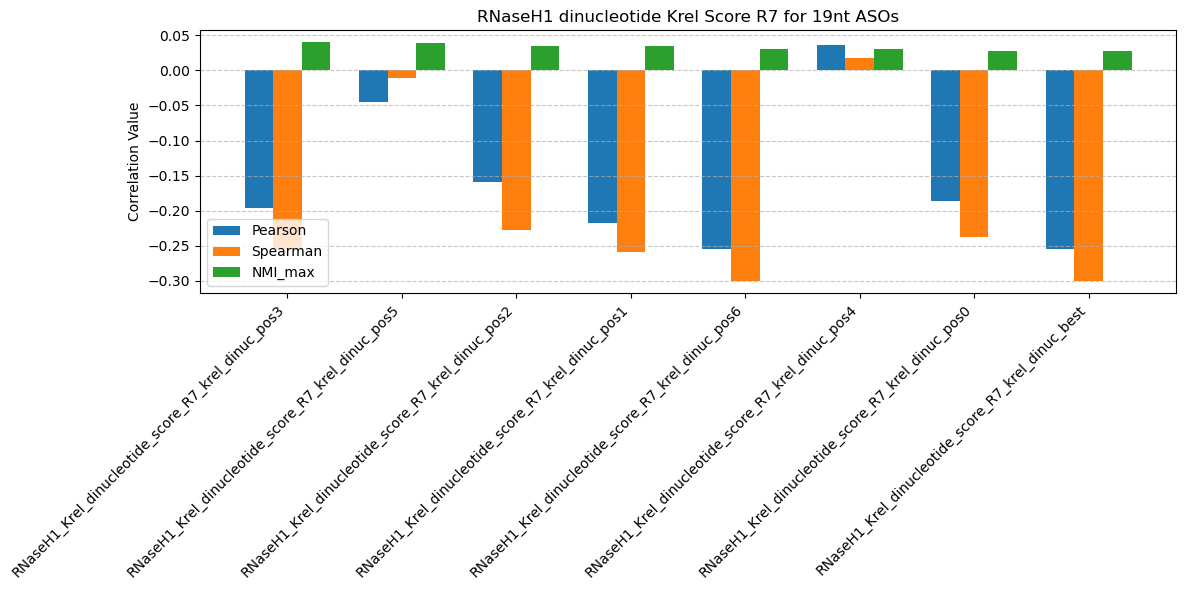

No features found starting with 'RNaseH1_Krel_dinucleotide_score_R7_krel'


In [147]:
plot_feature_correlations_by_prefix(results_df_16, prefix='RNaseH1_Krel_dinucleotide_score_R7_krel', title='RNaseH1 dinucleotide Krel Score R7 for 16nt ASOs')
plot_feature_correlations_by_prefix(results_df_17, prefix='RNaseH1_Krel_dinucleotide_score_R7_krel', title='RNaseH1 dinucleotide Krel Score R7 for 17nt ASOs')
plot_feature_correlations_by_prefix(results_df_20, prefix='RNaseH1_Krel_dinucleotide_score_R7_krel', title='RNaseH1 dinucleotide Krel Score R7 for 20nt ASOs')
plot_feature_correlations_by_prefix(results_df_18, prefix='RNaseH1_Krel_dinucleotide_score_R7_krel', title='RNaseH1 dinucleotide Krel Score R7 for 18nt ASOs') 
plot_feature_correlations_by_prefix(results_df_19, prefix='RNaseH1_Krel_dinucleotide_score_R7_krel', title='RNaseH1 dinucleotide Krel Score R7 for 19nt ASOs')
plot_feature_correlations_by_prefix(results_df_15, prefix='RNaseH1_Krel_dinucleotide_score_R7_krel', title='RNaseH1 dinucleotide Krel Score R7 for 15nt ASOs')

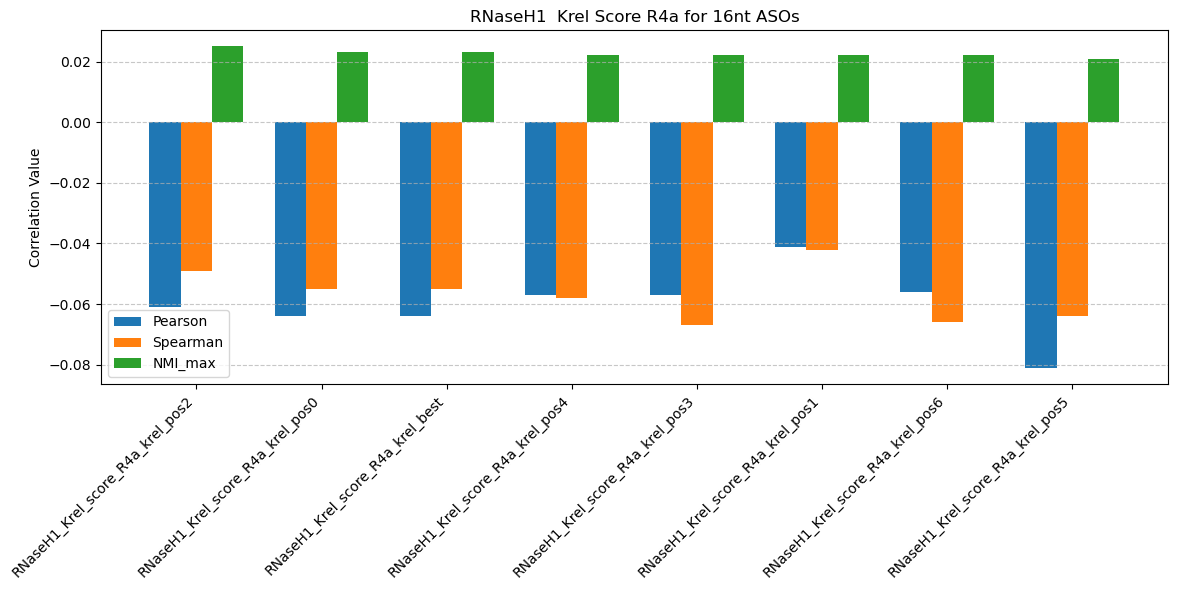

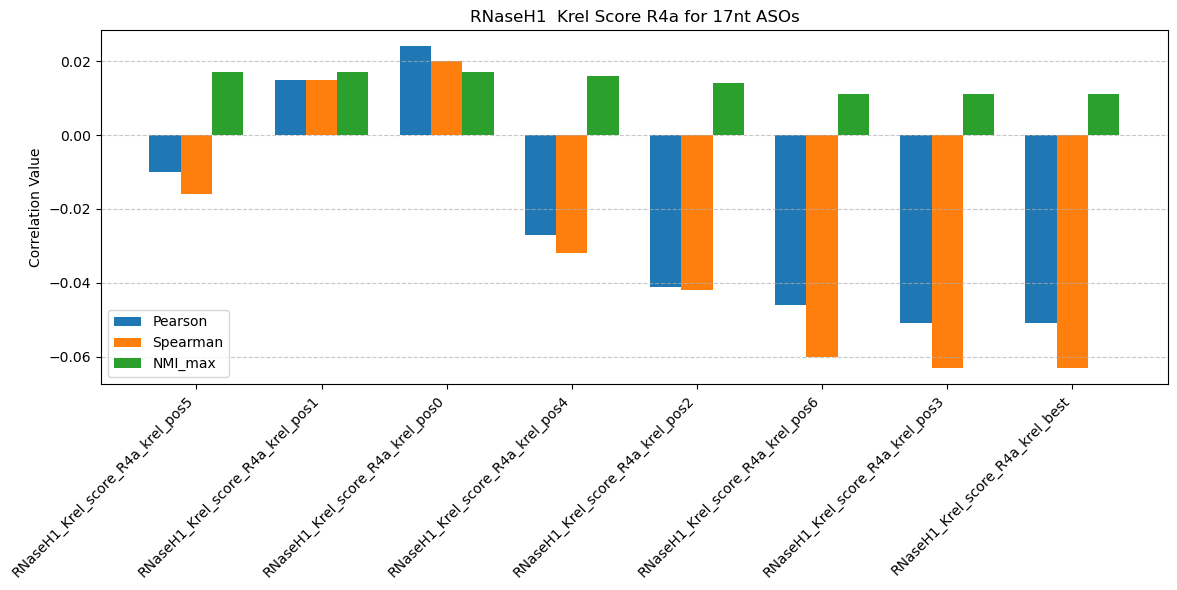

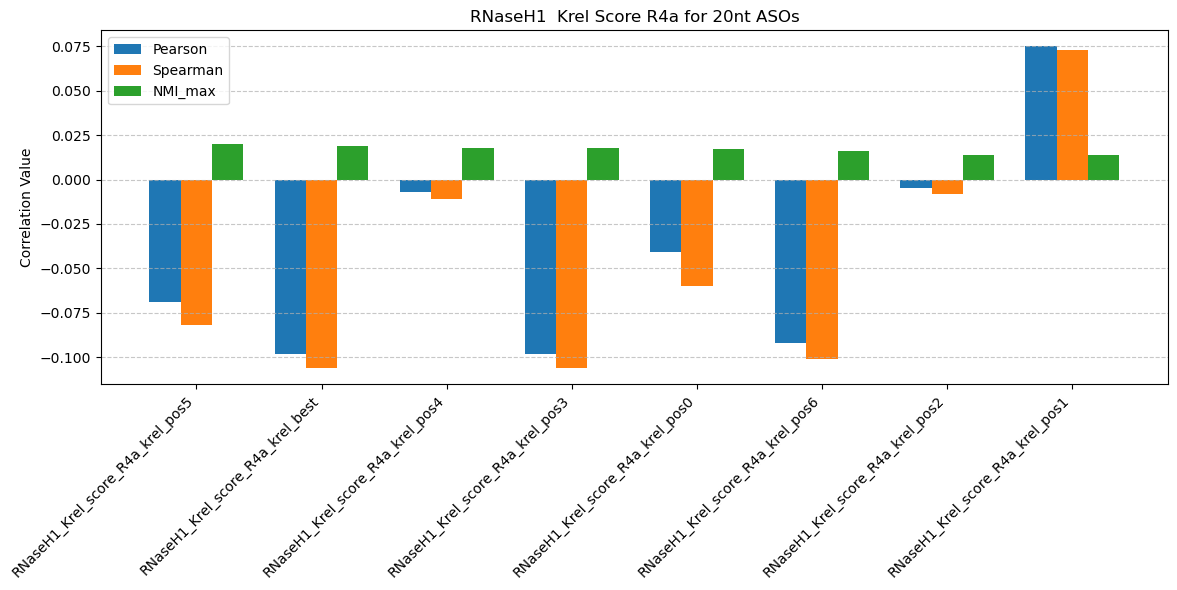

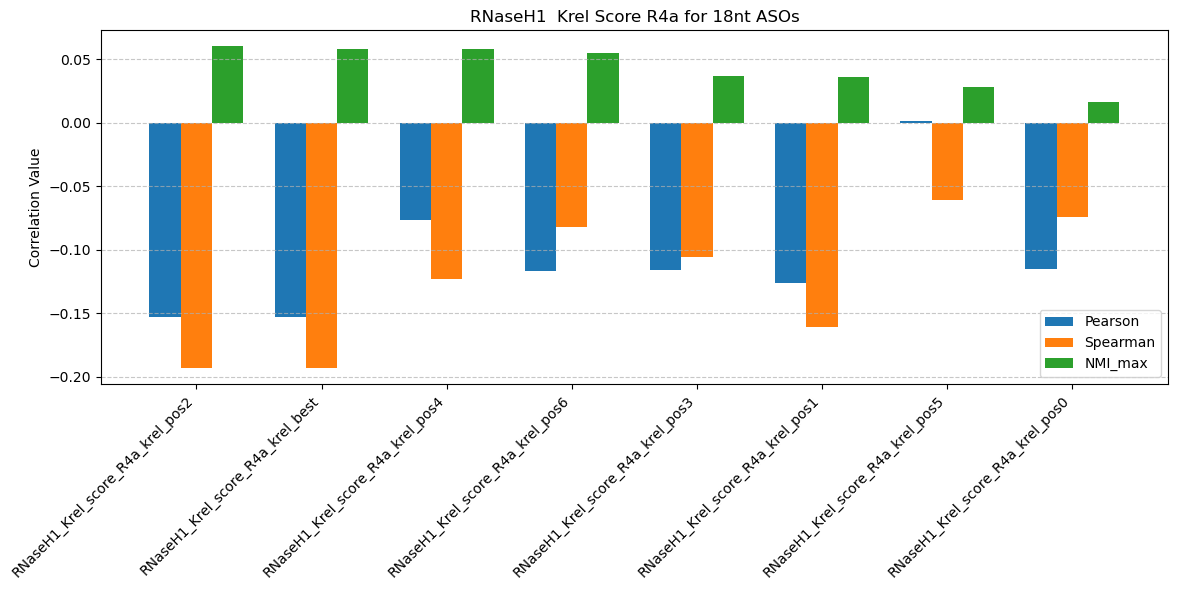

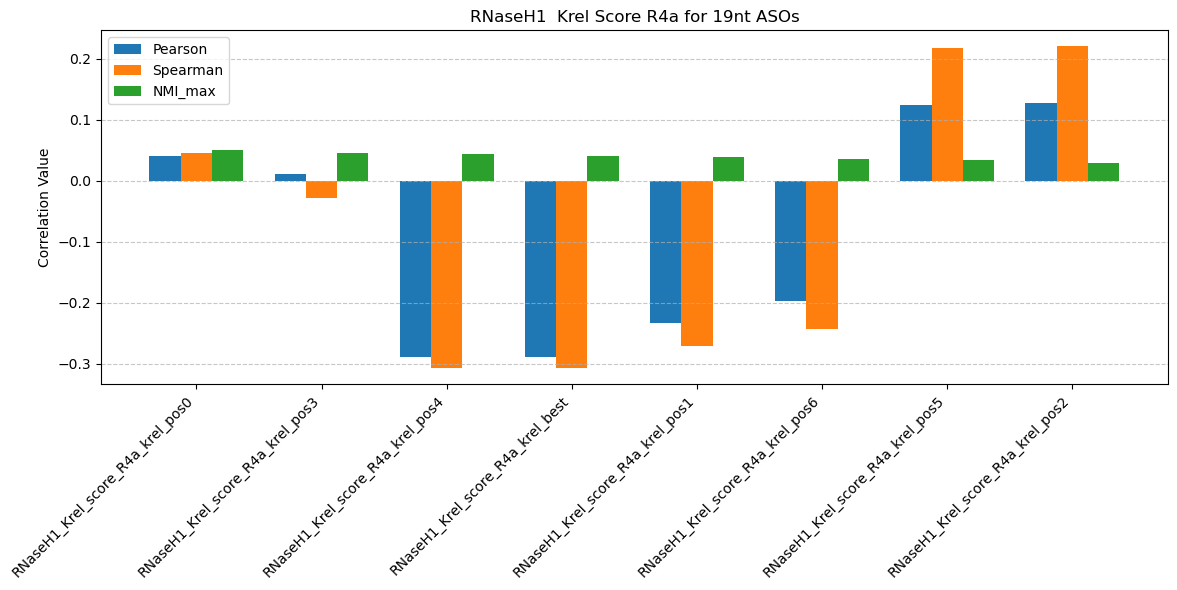

No features found starting with 'RNaseH1_Krel_score_R4a_krel'


In [148]:
plot_feature_correlations_by_prefix(results_df_16, prefix='RNaseH1_Krel_score_R4a_krel', title='RNaseH1  Krel Score R4a for 16nt ASOs')
plot_feature_correlations_by_prefix(results_df_17, prefix='RNaseH1_Krel_score_R4a_krel', title='RNaseH1  Krel Score R4a for 17nt ASOs')
plot_feature_correlations_by_prefix(results_df_20, prefix='RNaseH1_Krel_score_R4a_krel', title='RNaseH1  Krel Score R4a for 20nt ASOs')
plot_feature_correlations_by_prefix(results_df_18, prefix='RNaseH1_Krel_score_R4a_krel', title='RNaseH1  Krel Score R4a for 18nt ASOs') 
plot_feature_correlations_by_prefix(results_df_19, prefix='RNaseH1_Krel_score_R4a_krel', title='RNaseH1  Krel Score R4a for 19nt ASOs')
plot_feature_correlations_by_prefix(results_df_15, prefix='RNaseH1_Krel_score_R4a_krel', title='RNaseH1  Krel Score R4a for 15nt ASOs')

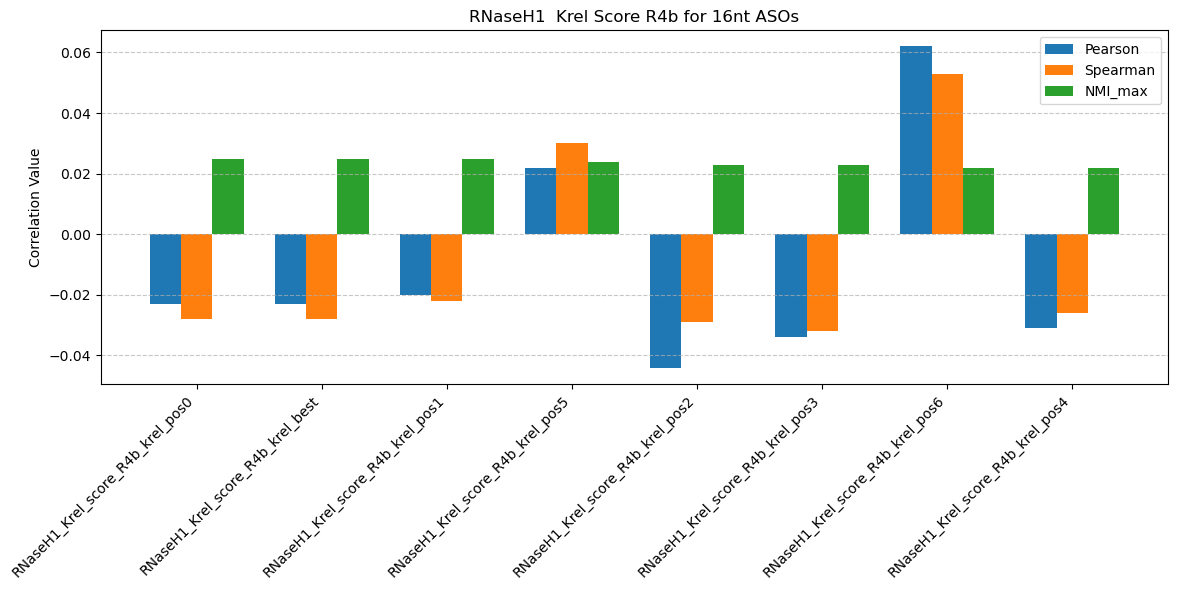

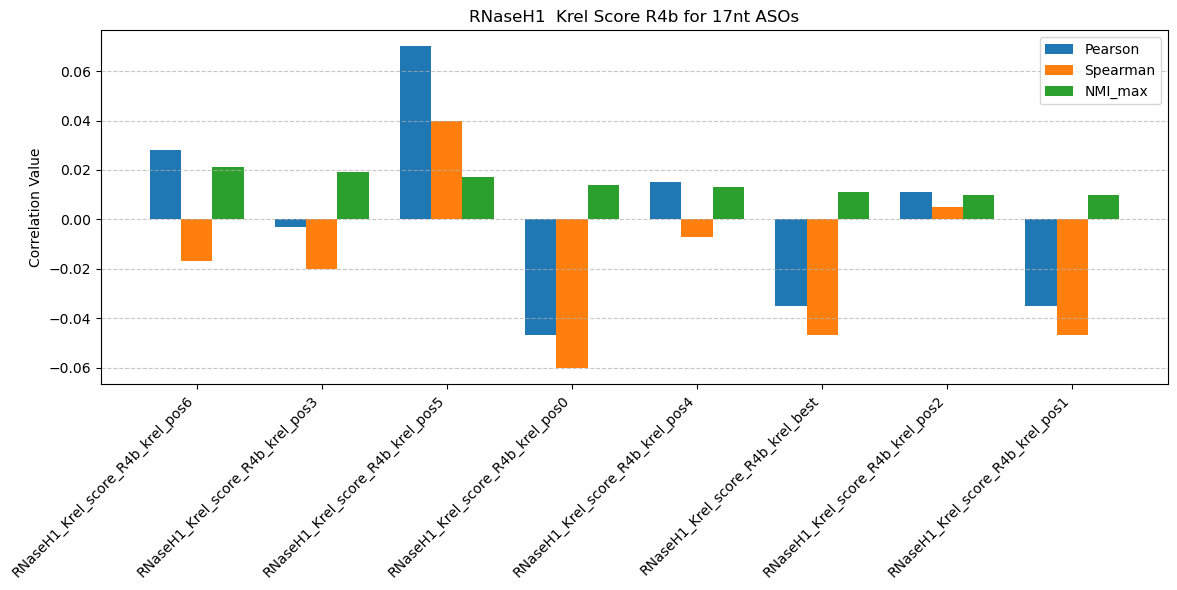

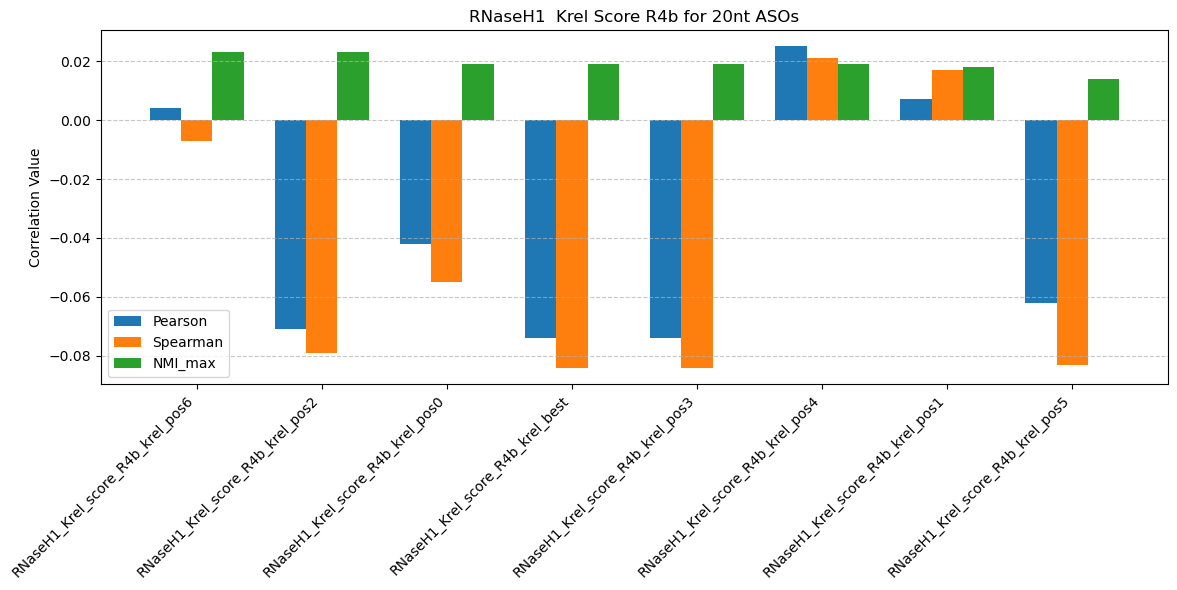

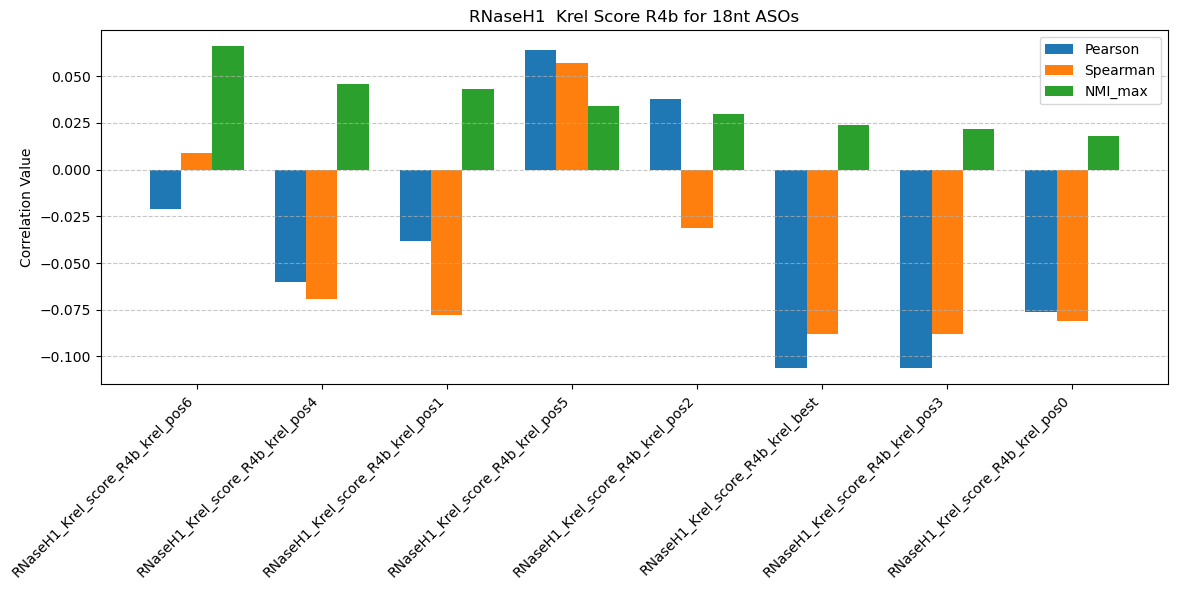

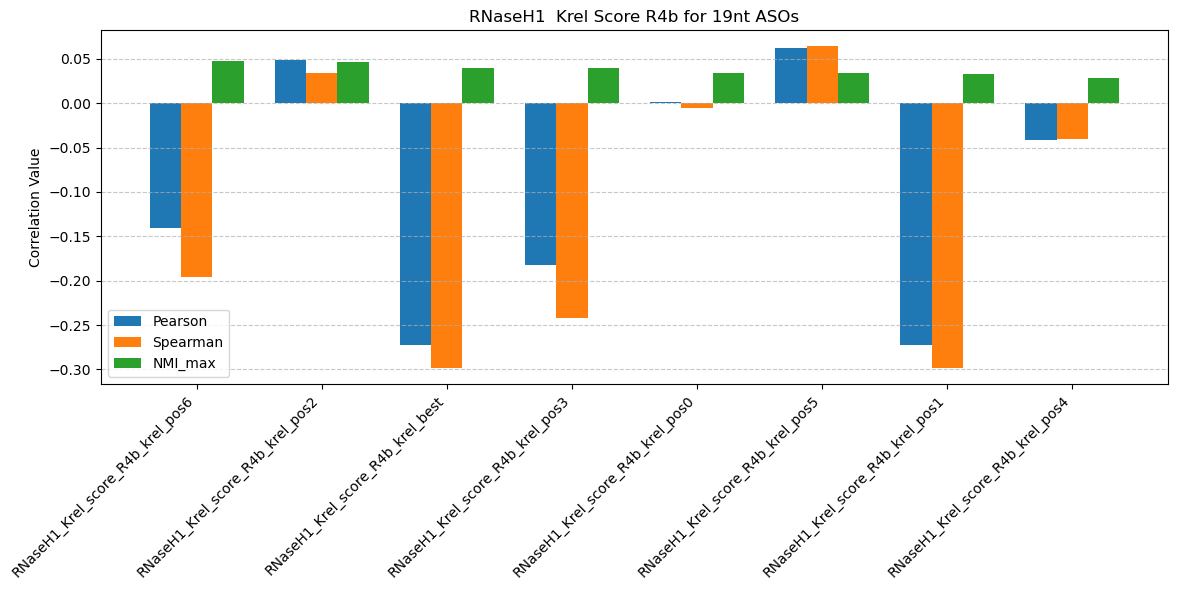

No features found starting with 'RNaseH1_Krel_score_R4b_krel'


In [149]:
plot_feature_correlations_by_prefix(results_df_16, prefix='RNaseH1_Krel_score_R4b_krel', title='RNaseH1  Krel Score R4b for 16nt ASOs')
plot_feature_correlations_by_prefix(results_df_17, prefix='RNaseH1_Krel_score_R4b_krel', title='RNaseH1  Krel Score R4b for 17nt ASOs')
plot_feature_correlations_by_prefix(results_df_20, prefix='RNaseH1_Krel_score_R4b_krel', title='RNaseH1  Krel Score R4b for 20nt ASOs')
plot_feature_correlations_by_prefix(results_df_18, prefix='RNaseH1_Krel_score_R4b_krel', title='RNaseH1  Krel Score R4b for 18nt ASOs') 
plot_feature_correlations_by_prefix(results_df_19, prefix='RNaseH1_Krel_score_R4b_krel', title='RNaseH1  Krel Score R4b for 19nt ASOs')
plot_feature_correlations_by_prefix(results_df_15, prefix='RNaseH1_Krel_score_R4b_krel', title='RNaseH1  Krel Score R4b for 15nt ASOs')

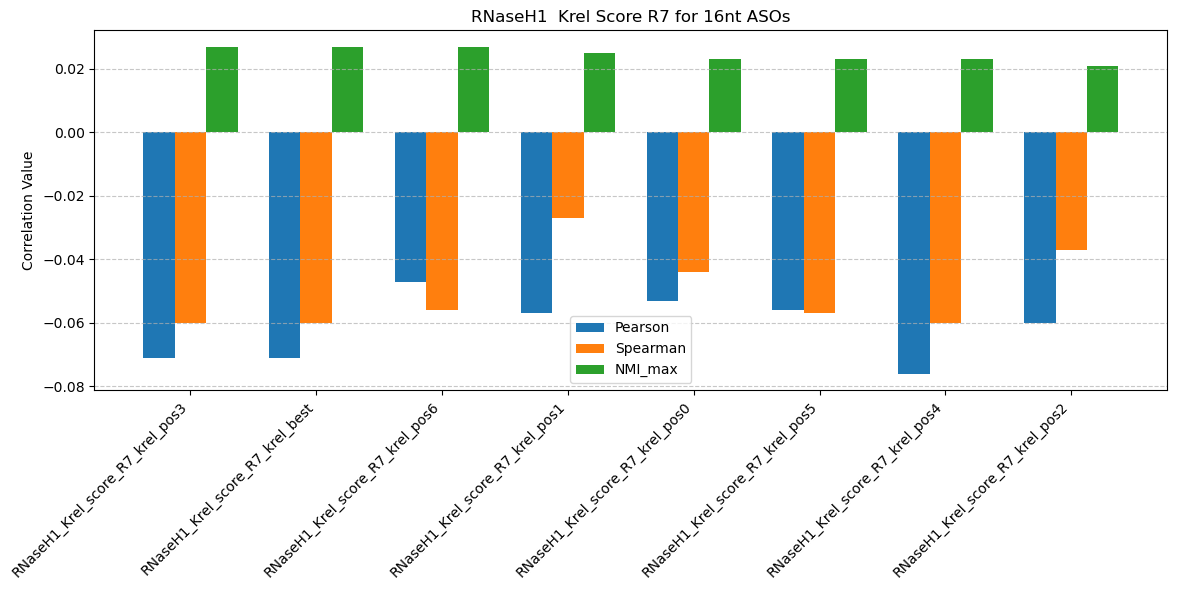

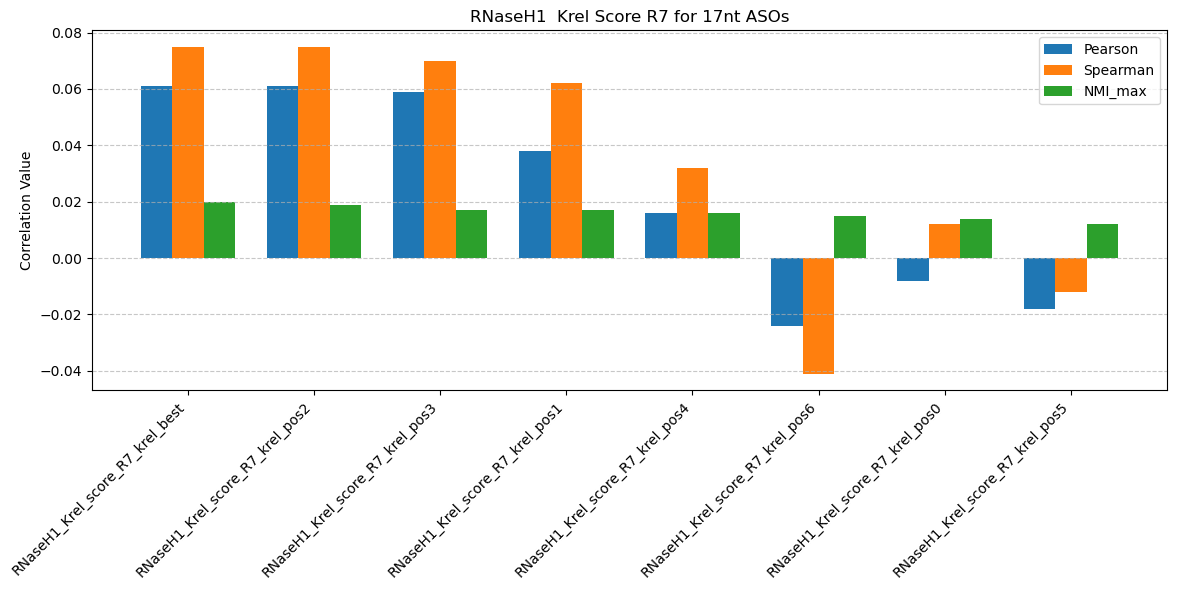

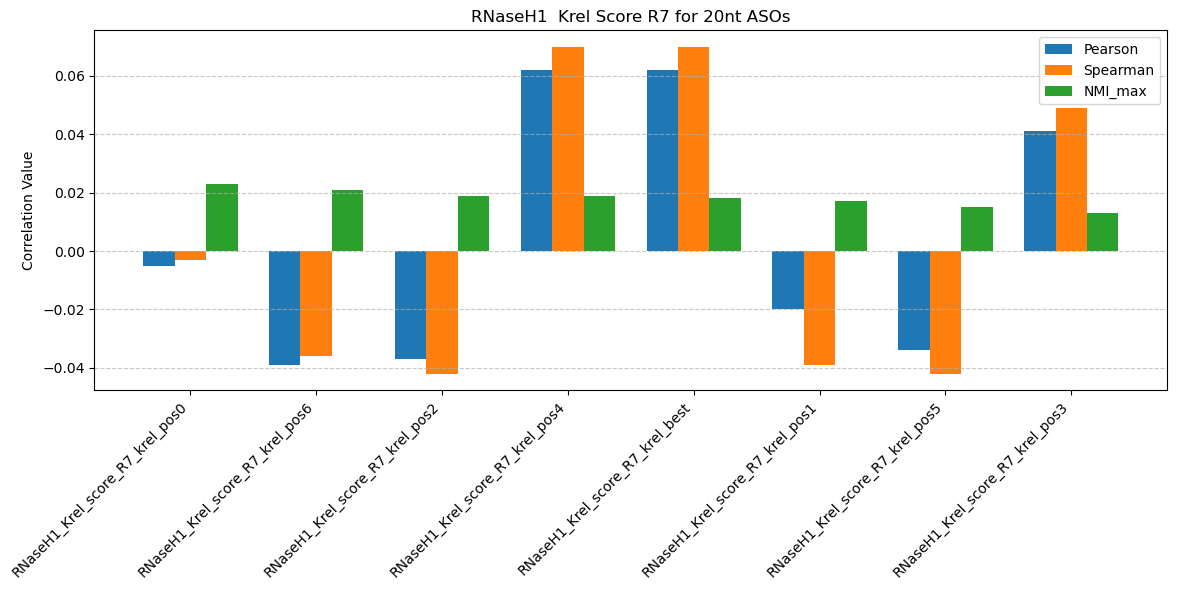

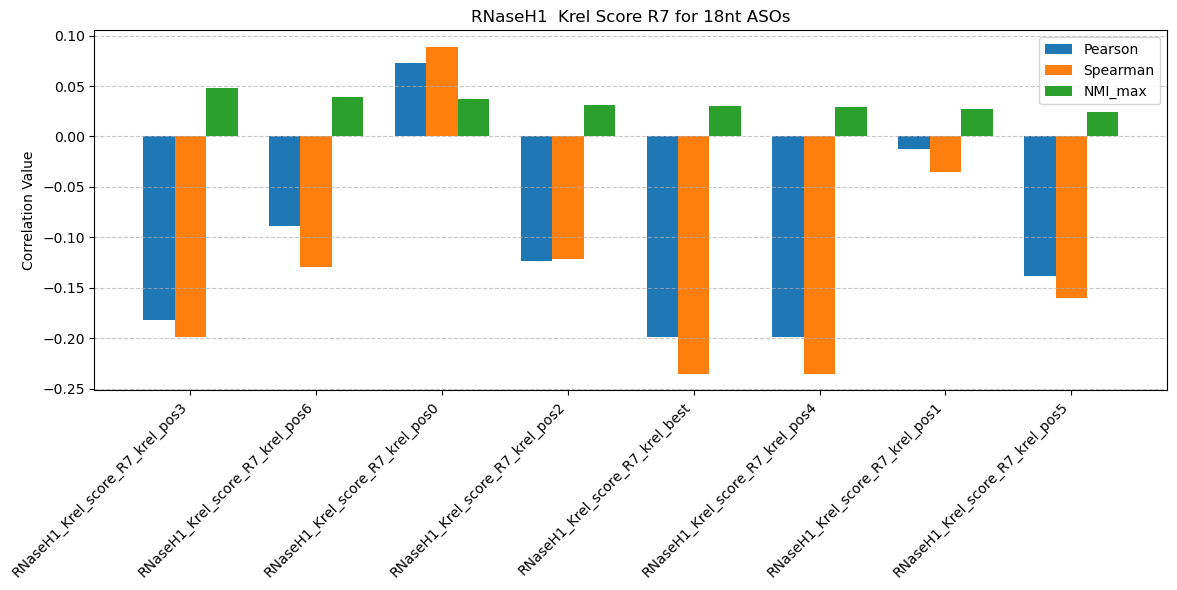

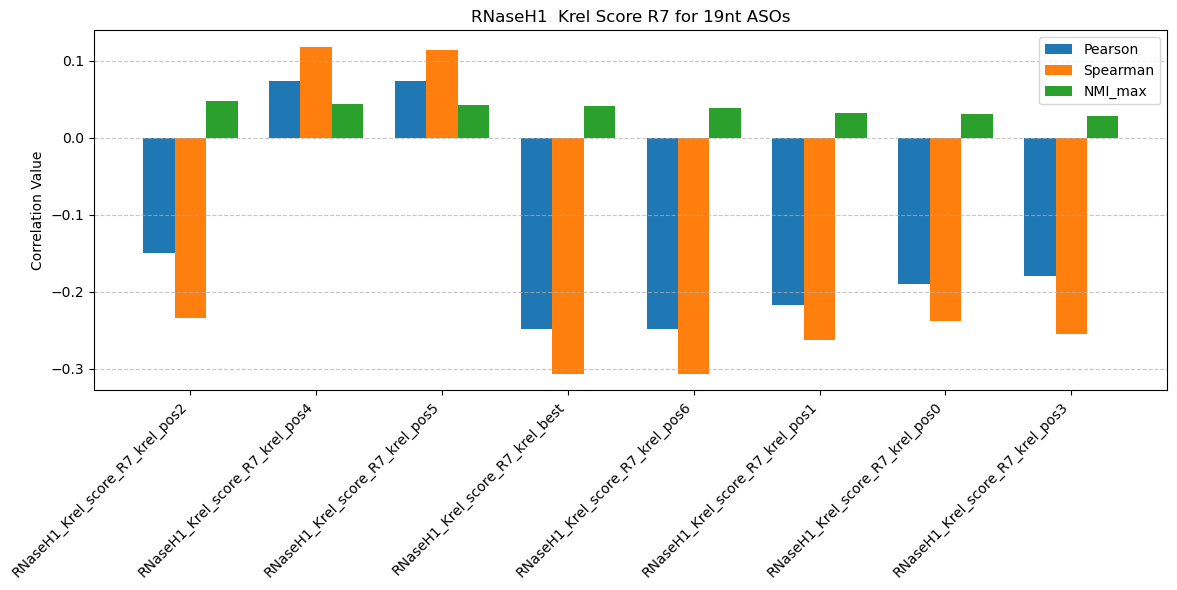

No features found starting with 'RNaseH1_Krel_score_R7_krel'


In [150]:
plot_feature_correlations_by_prefix(results_df_16, prefix='RNaseH1_Krel_score_R7_krel', title='RNaseH1  Krel Score R7 for 16nt ASOs')
plot_feature_correlations_by_prefix(results_df_17, prefix='RNaseH1_Krel_score_R7_krel', title='RNaseH1  Krel Score R7 for 17nt ASOs')
plot_feature_correlations_by_prefix(results_df_20, prefix='RNaseH1_Krel_score_R7_krel', title='RNaseH1  Krel Score R7 for 20nt ASOs')
plot_feature_correlations_by_prefix(results_df_18, prefix='RNaseH1_Krel_score_R7_krel', title='RNaseH1  Krel Score R7 for 18nt ASOs') 
plot_feature_correlations_by_prefix(results_df_19, prefix='RNaseH1_Krel_score_R7_krel', title='RNaseH1  Krel Score R7 for 19nt ASOs')
plot_feature_correlations_by_prefix(results_df_15, prefix='RNaseH1_Krel_score_R7_krel', title='RNaseH1  Krel Score R7 for 15nt ASOs')

Remove the sequence columns

In [172]:

final_filtered = new_filtered[["index"] + RNaseH1_best_features_list+ RNeseH1_motif_features]

In [173]:
final_filtered.columns

Index(['index', 'RNaseH1_Krel_dinucleotide_score_R4a_krel_dinuc_best',
       'RNaseH1_Krel_dinucleotide_score_R4b_krel_dinuc_best',
       'RNaseH1_Krel_dinucleotide_score_R7_krel_dinuc_best',
       'RNaseH1_Krel_score_R4a_krel_best', 'RNaseH1_Krel_score_R4b_krel_best',
       'RNaseH1_Krel_score_R7_krel_best',
       'RNaseH1_score_dinucleotide_R4a_dinuc_best',
       'RNaseH1_score_dinucleotide_R4b_dinuc_best',
       'RNaseH1_score_dinucleotide_R7_dinuc_best', 'RNaseH1_score_R4a_best',
       'RNaseH1_score_R4b_best', 'RNaseH1_score_R7_best',
       'RNaseH1_motif_presence_TCCC', 'RNaseH1_motif_presence_GGGA',
       'RNaseH1_motif_presence_CGCG', 'RNaseH1_motif_presence_AGGA',
       'RNaseH1_motif_presence_TGCC', 'RNaseH1_motif_presence_CCCG',
       'RNaseH1_motif_presence_TTTT', 'RNaseH1_motif_presence_AAAA',
       'RNaseH1_motif_presence_CCCC', 'RNaseH1_motif_presence_GGGG',
       'RNaseH1_motif_presence_TTAA', 'RNaseH1_motif_presence_GCGC'],
      dtype='object')

 Save DataFrame as CSV in the current working directory

In [152]:
#new_filtered.to_csv("features_output_final.csv", index=False)
